<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/Copy_of_PROJETO__ESTRESSE_FIG_COHERENCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> # BIBLIOTECAS

In [ ]:
from IPython.display import clear_output

In [ ]:
! pip install open-ephys-python-tools

clear_output()

In [ ]:
! pip install pactools
clear_output()

In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt, hilbert
import seaborn as sn

from statsmodels.tsa.stattools import grangercausalitytests
from scipy import stats
from scipy.stats import wilcoxon

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat

import pactools
from pactools import Comodulogram, REFERENCES

import seaborn as sns

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

> # FUNÇÕES



In [ ]:
def preview(path):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t)))

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  data_filt = signal.filtfilt(b, a, data)

  return (pd.DataFrame(data_filt))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def preview_plot(data):

  for i in range(0,32):
    plt.figure()
    plt.plot(data[i])
    plt.title('ch' + str (i+1))

In [ ]:
# CARREGAR O DADO E EXTRAIR MOMENTOS DE IMOBILIDADE

def load_data(path,inicio,final,ch_prl,ch_ca1d,ch_ca1v,ch_bla):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_bla)-1)]
  data_ca1d = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_ca1d)-1)]
  data_ca1v = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[inicio:final,int(int(ch_ca1v)-1)]


  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  CA1D = signal.filtfilt(b, a, data_ca1d)
  CA1V = signal.filtfilt(b, a, data_ca1v)


  return(pd.DataFrame({'data_PRL': PRL,'data_BLA': BLA, 'data_dhpc': CA1D, 'data_vhpc': CA1V}))

In [ ]:
def media_coherence(df, condicao, r1, r2, grupo):
    filtro = (df['condicao'] == condicao) & (df['r1'] == r1) & (df['r2'] == r2) & (df['grupo'] == grupo)
    media_coherence = df[filtro].groupby('animal')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao,'grupo': grupo})
    return result_df

In [ ]:
# Função para mapear o valor da frequencia da coerencia para o nome da banda
def mapear_banda(valor):
    if 0 <= valor <= 4:
        return 'Delta'
    elif 4.01 <= valor <= 10:
        return 'Theta'
    elif 10.01 <= valor <= 30:
        return 'Alpha/beta'
    elif 30.01 <= valor <= 50:
        return 'Low gamma'
    elif 50.01 <= valor <= 90:
        return 'Mid gamma'
    elif valor >=90.01:
        return 'High gamma'

In [ ]:
def load_acelerometer(path):
    load = Session(path).recordnodes[0].recordings[0]
    t_raw = load.continuous[0].timestamps
    t = t_raw - t_raw[0]

    x = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 32]
    y = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 33]
    z = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:, 34]

    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    acel = np.abs(np.sqrt(x**2 + y**2 + z**2))

    df_acel = pd.DataFrame({'acel': acel})
    df_acel['animal'] = str(rato)
    df_acel['condicao'] = str(condicao)

    return df_acel

In [ ]:
def group_consecutive_numbers(num_list):
    groups = []  # Lista para armazenar os grupos de números consecutivos
    current_group = [num_list[0]]  # Inicializando o primeiro grupo com o primeiro número

    # Iterando sobre a lista de números a partir do segundo elemento
    for num in num_list[1:]:
        if num == current_group[-1] + 1:  # Verificando se o número é consecutivo
            current_group.append(num)  # Se for, adiciona ao grupo atual
        else:
            groups.append(current_group)  # Se não, salva o grupo atual
            current_group = [num]  # Começa um novo grupo

    # Adicionando o último grupo se ele não estiver vazio
    if current_group:
        groups.append(current_group)

    return groups

In [ ]:
def concatenar_listas(lista_de_listas):
    """Concatena uma lista de listas em uma única lista.

    Returns:
   Uma única lista com todos os elementos das sub-listas.
    """
    return [item for sublist in lista_de_listas for item in sublist]

In [ ]:
def load_data_full(path,ch_prl,ch_bla,ch_dhpc, ch_vhpc):
  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  # tive que ecolher esse len pq o CCM559 tinha 30 min de dado, então padronizei p todos 10min
  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_bla)-1)]
  data_dhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_dhpc)-1)]
  data_vhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_vhpc)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  dHPC = signal.filtfilt(b, a, data_dhpc)
  vHPC = signal.filtfilt(b, a, data_vhpc)

  return(pd.DataFrame({'data_PRL': PRL,'data_BLA': BLA, 'data_DHPC': dHPC, 'data_VHPC': vHPC}))

In [ ]:
def data_slicing_imovel( rato, condicao ): #cria lista que contém os momentos de imobilidade

  path = ratos[str(rato)]['condicao'][str(condicao)]

  ch_prl =  ratos[rato]['canais']['prl']
  ch_bla =  ratos[rato]['canais']['bla']
  ch_dhpc =  ratos[rato]['canais']['dhpc']
  ch_vhpc =  ratos[rato]['canais']['vhpc']

  load = Session(path).recordnodes[0].recordings[0]
  t_raw= load.continuous[0].timestamps
  t = t_raw-t_raw[0]

  data_prl = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_prl)-1)]
  data_bla = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_bla)-1)]
  data_dhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_dhpc)-1)]
  data_vhpc = pd.DataFrame(load.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t))).iloc[:,int(int(ch_vhpc)-1)]

  srate = 1000
  fc_low = 59
  fc_high = 61
  order = 5
  b, a = signal.butter(order, [fc_low/(0.5*srate), fc_high/(0.5*srate)], btype='bandstop')

  PRL = signal.filtfilt(b, a, data_prl)
  BLA = signal.filtfilt(b, a, data_bla)
  dHPC = signal.filtfilt(b, a, data_dhpc)
  vHPC = signal.filtfilt(b, a, data_vhpc)

  # Recuperando dado da acelerometria para definir momentos de atividade
  data_acel = df_acel[(df_acel['animal'] == str(rato)) & (df_acel['condicao'] == str(condicao))]['acel']

  acel = np.array(data_acel)
  acel = np.diff(acel, axis = 0)
  acel = abs(pd.DataFrame(acel)).rolling(window=1000).mean()

  # array booleano dizendo onde animal mexeu e não mexeu
  parado_bool = np.array(acel <= 0.005 )

  index_parado_all = []
  for x in range(len(parado_bool)):
      if parado_bool[x] == True:
        index_parado_all.append(x)

  group_index_parado = group_consecutive_numbers(index_parado_all) #essa função irá agrupar números que são consecutivos em listas separadas

  index_parado = []

  for i in range(len(group_index_parado)): #esse for está selecionando apenas as listas que tem mais de 2s de dado
    if len(group_index_parado[i]) > 2000:
      index_parado.append(group_index_parado[i])

  PRL_cut = [] # ESSA LISTA VAI CONTER OS MOMENTOS DE IMOBILIDADE DO RATO CORRESPONDENTE (ela que será concatenada)

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      PRL_cut.append(PRL[inicio:final])

  BLA_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      BLA_cut.append(BLA[inicio:final])

  dHPC_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      dHPC_cut.append(dHPC[inicio:final])

  vHPC_cut = []

  for i in range(len(index_parado)):
      inicio = index_parado[i][0]
      final = index_parado[i][-1]

      vHPC_cut.append(vHPC[inicio:final])

  return PRL_cut, BLA_cut, dHPC_cut, vHPC_cut

In [ ]:
# FILTRO SIMPLES

def eegfilt(data,srate,flow,fhigh):

    # fir LS
    trans = 0.15
    nyq = srate*0.5
    f=[0, (1-trans)*flow/nyq, flow/nyq, fhigh/nyq, (1+trans)*fhigh/nyq, 1]
    m=[0,0,1,1,0,0]
    filt_order = 3*np.fix(srate/flow)
    if filt_order % 2 == 0:
        filt_order = filt_order + 1

    filtwts = signal.firls(filt_order,f,np.double(m))
    data_filt = signal.filtfilt(filtwts,1, data)

    return(data_filt)

    return(data_filt)

In [ ]:
#ExTRAINDO O MODULATION INDEX

def modulation_index(amp,fase_lenta,numbin):

    position=np.zeros(numbin) # this variable will get the beginning (not the center) of each phase bin (in rads)
    winsize = 2*np.pi/numbin # bin de fase

    position = []
    for j in np.arange(1,numbin+1):
        position.append(-np.pi+(j-1)*winsize)

    nbin=numbin
    mean_amp = []
    for j in np.arange(0,nbin):
        boolean_array = np.logical_and(fase_lenta >=  position[j], fase_lenta < position[j]+winsize)
        I = np.where(boolean_array)[0]
        mean_amp.append(np.mean(amp[I]))

    mean_amp = [x for x in mean_amp if str(x) != 'nan']
    p = mean_amp/np.sum(mean_amp)

    entrop = -1*(np.sum(p*np.log(p)))
    mi = (np.log(numbin)-entrop)/np.log(numbin)

    return(mi)

In [ ]:
# ACOP FASE AMPL PARA UMA REGIÃO

def pac(lfp,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))

    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))

    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))

    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# ACOP FASE AMPL ENTRE DUAS REGIÕES

def pac_entre_regioes(lfp_alta,lfp_lenta,lentaVector,altaVector,lenta_BandWidth,alta_BandWidth,srate,numbin):

    AmpFreqTransformed1 = []
    PhaseFreq = []

    pac_mi = []

    for ii in altaVector:
        Af1 = ii
        Af2=Af1+alta_BandWidth

        AmpFreq1=eegfilt(lfp_alta,srate,Af1,Af2) # just filtering

        analytic_signal1 = signal.hilbert(AmpFreq1)
        AmpFreqTransformed1.append(np.abs(analytic_signal1))


    faselenta = []
    for jj in lentaVector:
        Pf1 = jj
        Pf2 = Pf1 + lenta_BandWidth
        PhaseFreq=eegfilt(lfp_lenta,srate,Pf1,Pf2)
        analytic_signal = signal.hilbert(PhaseFreq)
        faselenta.append(np.angle(analytic_signal))


    fase_lenta = faselenta

    comodulogram = np.empty((len(lentaVector),len(altaVector)))


    for count_lenta,lenta in enumerate(fase_lenta):

        for count_rapida,rapida in enumerate(AmpFreqTransformed1):

            comodulogram[count_lenta,count_rapida] = modulation_index(rapida,lenta,numbin)


    return(comodulogram)

In [ ]:
# Causalidade de granger

def grangercausality(data1,data2,r1, r2, condicao, rato,frate,flow,fhigh):

  envelope_data_1 = np.abs(signal.hilbert(eegfilt(data1,frate,flow,fhigh)))
  test_data_1 = np.squeeze(envelope_data_1)

  envelope_data_2 = np.abs(signal.hilbert(eegfilt(data2,frate,flow,fhigh)))
  test_data_2 = np.squeeze(envelope_data_2)

  matrix_test = np.vstack([np.diff(test_data_1),np.diff(test_data_2)]).T
  lag = [int(math.sqrt(len(matrix_test)))]
  gc = grangercausalitytests(matrix_test,lag,verbose = False)
  results_test_r = [gc[lag[0]][0]['ssr_ftest'][1],gc[lag[0]][0]['ssr_ftest'][0]]

  p_label = []
  p = results_test_r[0]
  if p <= 0.01:
    p_label.append('p<0.01')
  elif 0.01 < p < 0.05:
    p_label.append('p<0.05')
  elif p == 0.05:
    p_label.append('p=0.05')
  else:
    p_label.append('p>0.05')

  df_granger = pd.DataFrame({ 'Granger Causality':  results_test_r[1], 'P value': p_label, 'r1': r1, 'r2': r2, 'condicao': condicao}, index=['Results'])

  return(df_granger )

> # ANÁLISE DOS DADOS

In [ ]:
# ATENÇÃO: aqui os canais iniciam em 1 e não em 0 (i+1), ou seja, ch1 == ch0, ch32 == ch31....


#'CCM64': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_24_08_2023/GRUPO_ESCAPAVEL/CCM64_OF_PRE_EXP',
                      #              'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_24_08_2023/GRUPO_ESCAPAVEL/CCM64_OF_POS_EXP'},
                      # 'grupo': { 'ESCAPAVEL'},

                      # 'canais': {'prl': 22,
                      #             'cg': 31,
                      #             'il': 25 ,
                      #             'ca1-d': 1 ,
                      #             'ca1-v': 14 ,
                      #             'bla': 19 },

                      # 'inicio': { 'OF_pre': 1000 ,
                      #             'OF_pos': 345000} },  # ESTE ANIMAL ESTÁ SÓ COM 4S DE REGISTRO DE OF POS EXP!!!!!!



          # 'CCM04': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO INESCAPAVEL/CCM04_OF_PRE_EXP',
          #                          'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO INESCAPAVEL/CCM04_OF_POS_EXP'},
          #             'grupo': 'INESCAPAVEL',

          #             'canais': {'prl': 22 ,
          #                         'cg': 29 ,
          #                         'il': 27 ,
          #                         'ca1-d':11 ,
          #                         'ca1-v': 13 ,
          #                         'bla': 19 },

          #             'inicio': { 'OF_pre': 90000  ,
          #                         'OF_pos': 1000 } },   # OF PRE ESTÁ SÓ COM 20000 PONTOS!!!!!!!

ratos = { 'CCM68': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_PRE_EXP',
                                         'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_28_08_2023/GRUPO ESCAPAVEL/CCM68_OF_POS_EXP'},

                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl':31 ,
                                  'cg':23 ,
                                  'il': 27 ,
                                  'dhpc': 1 ,
                                  'vhpc': 12 ,
                                  'bla':20  },

                      'inicio': { 'OF_pre': 270000 ,
                                  'OF_pos': 80000} }, # VERIFICADO OF PRE E POS OK

          'CCM65': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_31_08_2023/GRUPO ESCAPAVEL/CCM65_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_31_08_2023/GRUPO ESCAPAVEL/CCM65_OF_POS_EXP'},
                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl': 26 ,
                                  'cg': 32 ,
                                  'il': 24 ,
                                  'dhpc': 7 ,
                                  'vhpc': 16,
                                  'bla': 17 },

                      'inicio': { 'OF_pre': 1000  ,
                                  'OF_pos': 360000 } },  # VERIFICADO OF PRE E POS OK

          'CCM191': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_13_10_2023/GRUPO_ESCAPAVEL/CCM191_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_13_10_2023/GRUPO_ESCAPAVEL/CCM191_OF_POS_EXP'},
                      'grupo': 'ESCAPAVEL',

                      'canais': {'prl': 23,
                                  'cg': 31,
                                  'il': 28 ,
                                  'dhpc': 7 ,
                                  'vhpc': 11 ,
                                  'bla': 13  },

                      'inicio': { 'OF_pre': 20000 ,
                                  'OF_pos': 75000} },  # VERIFICADO OF PRE E POS OK

          'CCM05': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_08_2023/GRUPO INESCAPAVEL/CCM05_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_08_2023/GRUPO INESCAPAVEL/CCM05_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl': 24 ,
                                  'cg': 30,
                                  'il': 28 ,
                                  'dhpc': 6  ,
                                  'vhpc': 12 ,
                                  'bla': 17 },

                      'inicio': { 'OF_pre': 205000 ,
                                  'OF_pos': 265000 } },  # VERIFICADO OF PRE E POS OK

          'CCM192': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_25_10_2023/GRUPO INESCAPAVEL/CCM192_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl':22 ,
                                  'cg':31 ,
                                  'il': 27 ,
                                  'dhpc':5  ,
                                  'vhpc':12  ,
                                  'bla': 20 },

                      'inicio': { 'OF_pre': 140000 ,
                                  'OF_pos': 170000 } },   # VERIFICADO OF PRE E POS OK



          'CCM193': { 'condicao': {'OF_pre': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_10_2023/GRUPO INESCAPAVEL/CCM193_OF_PRE_EXP',
                                   'OF_pos': '/content/drive/Shareddrives/Stress 1K/PROJETO STRESS/EXP_30_10_2023/GRUPO INESCAPAVEL/CCM193_OF_POS_EXP'},
                      'grupo': 'INESCAPAVEL',

                      'canais': {'prl': 23,
                                  'cg': 29,
                                  'il': 25 ,
                                  'dhpc':6  ,
                                  'vhpc': 11 ,
                                  'bla': 19 },

                      'inicio': { 'OF_pre': 1000 ,
                                  'OF_pos': 268000} }}   # VERIFICADO OF PRE E POS OK



# DATA BASED ON ACELEROMETER

In [ ]:
# CRIANDO DF COM OS DADOS COMPLETOS

dataframes_full = []
for rato in ratos.keys():
  for condicao in ratos[rato]['condicao'].keys():

      path = ratos[str(rato)]['condicao'][str(condicao)]

      grupo = ratos[rato]['grupo']
      ch_prl =  ratos[rato]['canais']['prl']
      ch_bla = ratos[rato]['canais']['bla']
      ch_dhpc = ratos[rato]['canais']['dhpc']
      ch_vhpc = ratos[rato]['canais']['vhpc']

      df_temp_full = load_data_full(path,ch_prl,ch_bla,ch_dhpc, ch_vhpc)
      df_temp_full['animal'] = str(rato)
      df_temp_full['condicao'] = str(condicao)
      df_temp_full['grupo'] = str(grupo)

      dataframes_full.append(df_temp_full)

df_full = pd.concat(dataframes_full)
clear_output()

In [ ]:
# OBTENDO DADOS DO ACELEROMETRO

data_acel = []

for rato in ratos.keys():
    for condicao in ratos[rato]['condicao'].keys():
        path = ratos[str(rato)]['condicao'][str(condicao)]
        grupo = ratos[rato]['grupo']
        df_temp_acel = load_acelerometer(str(path))
        df_temp_acel['grupo'] = str(grupo)
        data_acel.append(df_temp_acel)

df_acel = pd.concat(data_acel)
clear_output()


In [ ]:
# CORTANDO MOMENTOS DE IMOBILIDADE A PARTIR DO ACELEROMETRO

# ESCAP
PRL_CCM68_PRE_P, BLA_CCM68_PRE_P , dHPC_CCM68_PRE_P, vHPC_CCM68_PRE_P = data_slicing_imovel( 'CCM68', 'OF_pre' ) #ESSA FUNÇÃO PRODUZ LISTAS QUE CONTÉM LISTAS COM MOMENTOS DE IMOBILIDADE POR MAIS DE 2S
PRL_CCM68_POS_P, BLA_CCM68_POS_P , dHPC_CCM68_POS_P, vHPC_CCM68_POS_P = data_slicing_imovel( 'CCM68', 'OF_pos' )

PRL_CCM65_PRE_P, BLA_CCM65_PRE_P , dHPC_CCM65_PRE_P, vHPC_CCM65_PRE_P = data_slicing_imovel( 'CCM65', 'OF_pre' )
PRL_CCM65_POS_P, BLA_CCM65_POS_P , dHPC_CCM65_POS_P, vHPC_CCM65_POS_P = data_slicing_imovel( 'CCM65', 'OF_pos' )

PRL_CCM191_PRE_P, BLA_CCM191_PRE_P , dHPC_CCM191_PRE_P, vHPC_CCM191_PRE_P = data_slicing_imovel( 'CCM191', 'OF_pre' )
PRL_CCM191_POS_P, BLA_CCM191_POS_P , dHPC_CCM191_POS_P, vHPC_CCM191_POS_P = data_slicing_imovel( 'CCM191', 'OF_pos' )


# INESCAP
PRL_CCM05_PRE_P, BLA_CCM05_PRE_P , dHPC_CCM05_PRE_P, vHPC_CCM05_PRE_P = data_slicing_imovel( 'CCM05', 'OF_pre' )
PRL_CCM05_POS_P, BLA_CCM05_POS_P , dHPC_CCM05_POS_P, vHPC_CCM05_POS_P = data_slicing_imovel( 'CCM05', 'OF_pos' )

PRL_CCM192_PRE_P, BLA_CCM192_PRE_P , dHPC_CCM192_PRE_P, vHPC_CCM192_PRE_P = data_slicing_imovel( 'CCM192', 'OF_pre' )
PRL_CCM192_POS_P, BLA_CCM192_POS_P , dHPC_CCM192_POS_P, vHPC_CCM192_POS_P = data_slicing_imovel( 'CCM192', 'OF_pos' )

PRL_CCM193_PRE_P, BLA_CCM193_PRE_P , dHPC_CCM193_PRE_P, vHPC_CCM193_PRE_P = data_slicing_imovel( 'CCM193', 'OF_pre' )
PRL_CCM193_POS_P, BLA_CCM193_POS_P , dHPC_CCM193_POS_P, vHPC_CCM193_POS_P = data_slicing_imovel( 'CCM193', 'OF_pos' )
clear_output()

In [ ]:
#essa função concatena as listas de dado do animal imóvel, até que some 90000 pontos (1min30s de dado) para fazer a coerência

def coherence_por_animal(lista_dados_1, lista_dados_2, rato, condicao, grupo, nome_r1, nome_r2):
    #
    # y = lista_dados_2[0]


  x = []
  contador = 0
  while len(x) < 90000:
    x.extend(lista_dados_1[contador])
    contador +=1

  y = []
  contador = 0
  while len(y) < 90000:
    y.extend(lista_dados_2[contador])
    contador +=1


    mask = min(len(x), len(y))

    f, coherence = signal.coherence(x[0:mask], y[0:mask], fs=1000, nperseg=1000, noverlap=int(0.5*1000),nfft = 10*1000)
    df_coherence = pd.DataFrame({'coherence': coherence, 'f': f, 'animal': str(rato), 'condicao': str(condicao), 'grupo': grupo, 'r1': nome_r1, 'r2': nome_r2, 'r1+r2': str(nome_r1)+'_'+str(nome_r2)})

    return df_coherence


In [ ]:

# ESCAPAVEL



coherence_ccm68_prl_bla_pre = coherence_por_animal(PRL_CCM68_PRE_P, BLA_CCM68_PRE_P, 'CCM68', 'PRE', 'ESCAPABLE', 'PRL', 'BLA' )
coherence_ccm68_prl_dhpc_pre = coherence_por_animal(PRL_CCM68_PRE_P, dHPC_CCM68_PRE_P, 'CCM68', 'PRE', 'ESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm68_prl_vhpc_pre = coherence_por_animal(PRL_CCM68_PRE_P, vHPC_CCM68_PRE_P, 'CCM68', 'PRE', 'ESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm68_bla_vhpc_pre = coherence_por_animal( BLA_CCM68_PRE_P,  vHPC_CCM68_PRE_P, 'CCM68', 'PRE', 'ESCAPABLE',  'BLA','vHPC' )
coherence_ccm68_bla_dhpc_pre = coherence_por_animal( BLA_CCM68_PRE_P,  dHPC_CCM68_PRE_P, 'CCM68', 'PRE', 'ESCAPABLE',  'BLA','dHPC' )

coherence_ccm68_dhpc_vhpc_pre = coherence_por_animal( dHPC_CCM68_PRE_P,  vHPC_CCM68_PRE_P, 'CCM68', 'PRE', 'ESCAPABLE',  'dHPC','vHPC' )


coherence_ccm68_prl_bla_pos = coherence_por_animal(PRL_CCM68_POS_P, BLA_CCM68_POS_P, 'CCM68', 'POS', 'ESCAPABLE', 'PRL', 'BLA' )
coherence_ccm68_prl_dhpc_pos = coherence_por_animal(PRL_CCM68_POS_P, dHPC_CCM68_POS_P, 'CCM68', 'POS', 'ESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm68_prl_vhpc_pos = coherence_por_animal(PRL_CCM68_POS_P, vHPC_CCM68_POS_P, 'CCM68', 'POS', 'ESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm68_bla_vhpc_pos = coherence_por_animal( BLA_CCM68_POS_P,  vHPC_CCM68_POS_P, 'CCM68', 'POS', 'ESCAPABLE',  'BLA','vHPC' )
coherence_ccm68_bla_dhpc_pos = coherence_por_animal( BLA_CCM68_POS_P,  dHPC_CCM68_POS_P, 'CCM68', 'POS', 'ESCAPABLE',  'BLA','dHPC' )

coherence_ccm68_dhpc_vhpc_pos = coherence_por_animal( dHPC_CCM68_POS_P,  vHPC_CCM68_POS_P, 'CCM68', 'POS', 'ESCAPABLE',  'dHPC','vHPC' )


coherence_ccm68 = pd.concat( [ coherence_ccm68_prl_bla_pre, coherence_ccm68_prl_dhpc_pre ,coherence_ccm68_prl_vhpc_pre,  coherence_ccm68_bla_vhpc_pre,  coherence_ccm68_bla_dhpc_pre, coherence_ccm68_dhpc_vhpc_pre,
                              coherence_ccm68_prl_bla_pos, coherence_ccm68_prl_dhpc_pos ,coherence_ccm68_prl_vhpc_pos,  coherence_ccm68_bla_vhpc_pos,  coherence_ccm68_bla_dhpc_pos, coherence_ccm68_dhpc_vhpc_pos]  )


In [ ]:
# ESCAPABLE

#PRE
coherence_ccm65_prl_bla_pre = coherence_por_animal(PRL_CCM65_PRE_P, BLA_CCM65_PRE_P, 'CCM65', 'PRE', 'ESCAPABLE', 'PRL', 'BLA' )
coherence_ccm65_prl_dhpc_pre = coherence_por_animal(PRL_CCM65_PRE_P, dHPC_CCM65_PRE_P, 'CCM65', 'PRE', 'ESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm65_prl_vhpc_pre = coherence_por_animal(PRL_CCM65_PRE_P, vHPC_CCM65_PRE_P, 'CCM65', 'PRE', 'ESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm65_bla_vhpc_pre = coherence_por_animal( BLA_CCM65_PRE_P,  vHPC_CCM65_PRE_P, 'CCM65', 'PRE', 'ESCAPABLE',  'BLA','vHPC' )
coherence_ccm65_bla_dhpc_pre = coherence_por_animal( BLA_CCM65_PRE_P,  dHPC_CCM65_PRE_P, 'CCM65', 'PRE', 'ESCAPABLE',  'BLA','dHPC' )

coherence_ccm65_dhpc_vhpc_pre = coherence_por_animal( dHPC_CCM65_PRE_P,  vHPC_CCM65_PRE_P, 'CCM65', 'PRE', 'ESCAPABLE',  'dHPC','vHPC' )

#POS
coherence_ccm65_prl_bla_pos = coherence_por_animal(PRL_CCM65_POS_P, BLA_CCM65_POS_P, 'CCM65', 'POS', 'ESCAPABLE', 'PRL', 'BLA' )
coherence_ccm65_prl_dhpc_pos = coherence_por_animal(PRL_CCM65_POS_P, dHPC_CCM65_POS_P, 'CCM65', 'POS', 'ESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm65_prl_vhpc_pos = coherence_por_animal(PRL_CCM65_POS_P, vHPC_CCM65_POS_P, 'CCM65', 'POS', 'ESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm65_bla_vhpc_pos = coherence_por_animal( BLA_CCM65_POS_P,  vHPC_CCM65_POS_P, 'CCM65', 'POS', 'ESCAPABLE',  'BLA','vHPC' )
coherence_ccm65_bla_dhpc_pos = coherence_por_animal( BLA_CCM65_POS_P,  dHPC_CCM65_POS_P, 'CCM65', 'POS', 'ESCAPABLE',  'BLA','dHPC' )

coherence_ccm65_dhpc_vhpc_pos = coherence_por_animal( dHPC_CCM65_POS_P,  vHPC_CCM65_POS_P, 'CCM65', 'POS', 'ESCAPABLE',  'dHPC','vHPC' )


coherence_ccm65 = pd.concat( [ coherence_ccm65_prl_bla_pre, coherence_ccm65_prl_dhpc_pre ,coherence_ccm65_prl_vhpc_pre,  coherence_ccm65_bla_vhpc_pre,  coherence_ccm65_bla_dhpc_pre, coherence_ccm65_dhpc_vhpc_pre,
                              coherence_ccm65_prl_bla_pos, coherence_ccm65_prl_dhpc_pos ,coherence_ccm65_prl_vhpc_pos,  coherence_ccm65_bla_vhpc_pos,  coherence_ccm65_bla_dhpc_pos, coherence_ccm65_dhpc_vhpc_pos]  )


In [ ]:
# ESCAPABLE



coherence_ccm191_prl_bla_pre = coherence_por_animal(PRL_CCM191_PRE_P, BLA_CCM191_PRE_P, 'CCM191', 'PRE', 'ESCAPABLE', 'PRL', 'BLA' )
coherence_ccm191_prl_dhpc_pre = coherence_por_animal(PRL_CCM191_PRE_P, dHPC_CCM191_PRE_P, 'CCM191', 'PRE', 'ESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm191_prl_vhpc_pre = coherence_por_animal(PRL_CCM191_PRE_P, vHPC_CCM191_PRE_P, 'CCM191', 'PRE', 'ESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm191_bla_vhpc_pre = coherence_por_animal( BLA_CCM191_PRE_P,  vHPC_CCM191_PRE_P, 'CCM191', 'PRE', 'ESCAPABLE',  'BLA','vHPC' )
coherence_ccm191_bla_dhpc_pre = coherence_por_animal( BLA_CCM191_PRE_P,  dHPC_CCM191_PRE_P, 'CCM191', 'PRE', 'ESCAPABLE',  'BLA','dHPC' )

coherence_ccm191_dhpc_vhpc_pre = coherence_por_animal( dHPC_CCM191_PRE_P,  vHPC_CCM191_PRE_P, 'CCM191', 'PRE', 'ESCAPABLE',  'dHPC','vHPC' )


coherence_ccm191_prl_bla_pos = coherence_por_animal(PRL_CCM191_POS_P, BLA_CCM191_POS_P, 'CCM191', 'POS', 'ESCAPABLE', 'PRL', 'BLA' )
coherence_ccm191_prl_dhpc_pos = coherence_por_animal(PRL_CCM191_POS_P, dHPC_CCM191_POS_P, 'CCM191', 'POS', 'ESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm191_prl_vhpc_pos = coherence_por_animal(PRL_CCM191_POS_P, vHPC_CCM191_POS_P, 'CCM191', 'POS', 'ESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm191_bla_vhpc_pos = coherence_por_animal( BLA_CCM191_POS_P,  vHPC_CCM191_POS_P, 'CCM191', 'POS', 'ESCAPABLE',  'BLA','vHPC' )
coherence_ccm191_bla_dhpc_pos = coherence_por_animal( BLA_CCM191_POS_P,  dHPC_CCM191_POS_P, 'CCM191', 'POS', 'ESCAPABLE',  'BLA','dHPC' )

coherence_ccm191_dhpc_vhpc_pos = coherence_por_animal( dHPC_CCM191_POS_P,  vHPC_CCM191_POS_P, 'CCM191', 'POS', 'ESCAPABLE',  'dHPC','vHPC' )


coherence_ccm191 = pd.concat( [ coherence_ccm191_prl_bla_pre, coherence_ccm191_prl_dhpc_pre ,coherence_ccm191_prl_vhpc_pre,  coherence_ccm191_bla_vhpc_pre,  coherence_ccm191_bla_dhpc_pre, coherence_ccm191_dhpc_vhpc_pre,
                              coherence_ccm191_prl_bla_pos, coherence_ccm191_prl_dhpc_pos ,coherence_ccm191_prl_vhpc_pos,  coherence_ccm191_bla_vhpc_pos,  coherence_ccm191_bla_dhpc_pos, coherence_ccm191_dhpc_vhpc_pos ]  )



In [ ]:
# INESCAP





coherence_ccm05_prl_bla_pre = coherence_por_animal(PRL_CCM05_PRE_P, BLA_CCM05_PRE_P, 'CCM05', 'PRE', 'INESCAPABLE', 'PRL', 'BLA' )
coherence_ccm05_prl_dhpc_pre = coherence_por_animal(PRL_CCM05_PRE_P, dHPC_CCM05_PRE_P, 'CCM05', 'PRE', 'INESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm05_prl_vhpc_pre = coherence_por_animal(PRL_CCM05_PRE_P, vHPC_CCM05_PRE_P, 'CCM05', 'PRE', 'INESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm05_bla_vhpc_pre = coherence_por_animal( BLA_CCM05_PRE_P,  vHPC_CCM05_PRE_P, 'CCM05', 'PRE', 'INESCAPABLE',  'BLA','vHPC' )
coherence_ccm05_bla_dhpc_pre = coherence_por_animal( BLA_CCM05_PRE_P,  dHPC_CCM05_PRE_P, 'CCM05', 'PRE', 'INESCAPABLE',  'BLA','dHPC' )

coherence_ccm05_dhpc_vhpc_pre = coherence_por_animal( dHPC_CCM05_PRE_P,  vHPC_CCM05_PRE_P, 'CCM05', 'PRE', 'INESCAPABLE',  'dHPC','vHPC' )




coherence_ccm05_prl_bla_pos = coherence_por_animal(PRL_CCM05_POS_P, BLA_CCM05_POS_P, 'CCM05', 'POS', 'INESCAPABLE', 'PRL', 'BLA' )
coherence_ccm05_prl_dhpc_pos = coherence_por_animal(PRL_CCM05_POS_P, dHPC_CCM05_POS_P, 'CCM05', 'POS', 'INESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm05_prl_vhpc_pos = coherence_por_animal(PRL_CCM05_POS_P, vHPC_CCM05_POS_P, 'CCM05', 'POS', 'INESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm05_bla_vhpc_pos = coherence_por_animal( BLA_CCM05_POS_P,  vHPC_CCM05_POS_P, 'CCM05', 'POS', 'INESCAPABLE',  'BLA','vHPC' )
coherence_ccm05_bla_dhpc_pos = coherence_por_animal( BLA_CCM05_POS_P,  dHPC_CCM05_POS_P, 'CCM05', 'POS', 'INESCAPABLE',  'BLA','dHPC' )

coherence_ccm05_dhpc_vhpc_pos = coherence_por_animal( dHPC_CCM05_POS_P,  vHPC_CCM05_POS_P, 'CCM05', 'POS', 'INESCAPABLE',  'dHPC','vHPC' )


coherence_ccm05 = pd.concat( [ coherence_ccm05_prl_bla_pre, coherence_ccm05_prl_dhpc_pre ,coherence_ccm05_prl_vhpc_pre,  coherence_ccm05_bla_vhpc_pre,  coherence_ccm05_bla_dhpc_pre, coherence_ccm05_dhpc_vhpc_pre,
                              coherence_ccm05_prl_bla_pos, coherence_ccm05_prl_dhpc_pos ,coherence_ccm05_prl_vhpc_pos,  coherence_ccm05_bla_vhpc_pos,  coherence_ccm05_bla_dhpc_pos, coherence_ccm05_dhpc_vhpc_pos]  )




In [ ]:
# INESCAP




coherence_ccm192_prl_bla_pre = coherence_por_animal(PRL_CCM192_PRE_P, BLA_CCM192_PRE_P, 'CCM192', 'PRE', 'INESCAPABLE', 'PRL', 'BLA' )
coherence_ccm192_prl_dhpc_pre = coherence_por_animal(PRL_CCM192_PRE_P, dHPC_CCM192_PRE_P, 'CCM192', 'PRE', 'INESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm192_prl_vhpc_pre = coherence_por_animal(PRL_CCM192_PRE_P, vHPC_CCM192_PRE_P, 'CCM192', 'PRE', 'INESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm192_bla_vhpc_pre = coherence_por_animal( BLA_CCM192_PRE_P,  vHPC_CCM192_PRE_P, 'CCM192', 'PRE', 'INESCAPABLE',  'BLA','vHPC' )
coherence_ccm192_bla_dhpc_pre = coherence_por_animal( BLA_CCM192_PRE_P,  dHPC_CCM192_PRE_P, 'CCM192', 'PRE', 'INESCAPABLE',  'BLA','dHPC' )

coherence_ccm192_dhpc_vhpc_pre = coherence_por_animal( dHPC_CCM192_PRE_P,  vHPC_CCM192_PRE_P, 'CCM192', 'PRE', 'INESCAPABLE',  'dHPC','vHPC' )


coherence_ccm192_prl_bla_pos = coherence_por_animal(PRL_CCM192_POS_P, BLA_CCM192_POS_P, 'CCM192', 'POS', 'INESCAPABLE', 'PRL', 'BLA' )
coherence_ccm192_prl_dhpc_pos = coherence_por_animal(PRL_CCM192_POS_P, dHPC_CCM192_POS_P, 'CCM192', 'POS', 'INESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm192_prl_vhpc_pos = coherence_por_animal(PRL_CCM192_POS_P, vHPC_CCM192_POS_P, 'CCM192', 'POS', 'INESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm192_bla_vhpc_pos = coherence_por_animal( BLA_CCM192_POS_P,  vHPC_CCM192_POS_P, 'CCM192', 'POS', 'INESCAPABLE',  'BLA','vHPC' )
coherence_ccm192_bla_dhpc_pos = coherence_por_animal( BLA_CCM192_POS_P,  dHPC_CCM192_POS_P, 'CCM192', 'POS', 'INESCAPABLE',  'BLA','dHPC' )

coherence_ccm192_dhpc_vhpc_pos = coherence_por_animal( dHPC_CCM192_POS_P,  vHPC_CCM192_POS_P, 'CCM192', 'POS', 'INESCAPABLE',  'dHPC','vHPC' )


coherence_ccm192 = pd.concat( [ coherence_ccm192_prl_bla_pre, coherence_ccm192_prl_dhpc_pre ,coherence_ccm192_prl_vhpc_pre,  coherence_ccm192_bla_vhpc_pre,  coherence_ccm192_bla_dhpc_pre, coherence_ccm192_dhpc_vhpc_pre,
                              coherence_ccm192_prl_bla_pos, coherence_ccm192_prl_dhpc_pos ,coherence_ccm192_prl_vhpc_pos,  coherence_ccm192_bla_vhpc_pos,  coherence_ccm192_bla_dhpc_pos, coherence_ccm192_dhpc_vhpc_pos]  )


In [ ]:
# INESCAP




coherence_ccm193_prl_bla_pre = coherence_por_animal(PRL_CCM193_PRE_P, BLA_CCM193_PRE_P, 'CCM193', 'PRE', 'INESCAPABLE', 'PRL', 'BLA' )
coherence_ccm193_prl_dhpc_pre = coherence_por_animal(PRL_CCM193_PRE_P, dHPC_CCM193_PRE_P, 'CCM193', 'PRE', 'INESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm193_prl_vhpc_pre = coherence_por_animal(PRL_CCM193_PRE_P, vHPC_CCM193_PRE_P, 'CCM193', 'PRE', 'INESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm193_bla_vhpc_pre = coherence_por_animal( BLA_CCM193_PRE_P,  vHPC_CCM193_PRE_P, 'CCM193', 'PRE', 'INESCAPABLE',  'BLA','vHPC' )
coherence_ccm193_bla_dhpc_pre = coherence_por_animal( BLA_CCM193_PRE_P,  dHPC_CCM193_PRE_P, 'CCM193', 'PRE', 'INESCAPABLE',  'BLA','dHPC' )

coherence_ccm193_dhpc_vhpc_pre = coherence_por_animal( dHPC_CCM193_PRE_P,  vHPC_CCM193_PRE_P, 'CCM193', 'PRE', 'INESCAPABLE',  'dHPC','vHPC' )



coherence_ccm193_prl_bla_pos = coherence_por_animal(PRL_CCM193_POS_P, BLA_CCM193_POS_P, 'CCM193', 'POS', 'INESCAPABLE', 'PRL', 'BLA' )
coherence_ccm193_prl_dhpc_pos = coherence_por_animal(PRL_CCM193_POS_P, dHPC_CCM193_POS_P, 'CCM193', 'POS', 'INESCAPABLE', 'PRL', 'dHPC' )
coherence_ccm193_prl_vhpc_pos = coherence_por_animal(PRL_CCM193_POS_P, vHPC_CCM193_POS_P, 'CCM193', 'POS', 'INESCAPABLE', 'PRL', 'vHPC' )

coherence_ccm193_bla_vhpc_pos = coherence_por_animal( BLA_CCM193_POS_P,  vHPC_CCM193_POS_P, 'CCM193', 'POS', 'INESCAPABLE',  'BLA','vHPC' )
coherence_ccm193_bla_dhpc_pos = coherence_por_animal( BLA_CCM193_POS_P,  dHPC_CCM193_POS_P, 'CCM193', 'POS', 'INESCAPABLE',  'BLA','dHPC' )

coherence_ccm193_dhpc_vhpc_pos = coherence_por_animal( dHPC_CCM193_POS_P,  vHPC_CCM193_POS_P, 'CCM193', 'POS', 'INESCAPABLE',  'dHPC','vHPC' )


coherence_ccm193 = pd.concat( [ coherence_ccm193_prl_bla_pre, coherence_ccm193_prl_dhpc_pre ,coherence_ccm193_prl_vhpc_pre,  coherence_ccm193_bla_vhpc_pre,  coherence_ccm193_bla_dhpc_pre, coherence_ccm193_dhpc_vhpc_pre,
                              coherence_ccm193_prl_bla_pos, coherence_ccm193_prl_dhpc_pos ,coherence_ccm193_prl_vhpc_pos,  coherence_ccm193_bla_vhpc_pos,  coherence_ccm193_bla_dhpc_pos, coherence_ccm193_dhpc_vhpc_pos]  )


In [ ]:
f = coherence_ccm68_prl_bla_pre['f']

mean_coherence_prl_bla_pre_escap = np.mean([coherence_ccm68_prl_bla_pre['coherence'] , coherence_ccm65_prl_bla_pre['coherence'], coherence_ccm191_prl_bla_pre['coherence']   ],axis = 0)
mean_coherence_prl_dhpc_pre_escap= np.mean([coherence_ccm68_prl_dhpc_pre['coherence'], coherence_ccm65_prl_dhpc_pre['coherence'], coherence_ccm191_prl_dhpc_pre['coherence'] ],axis = 0)
mean_coherence_prl_vhpc_pre_escap= np.mean([coherence_ccm68_prl_vhpc_pre['coherence'], coherence_ccm65_prl_vhpc_pre['coherence'], coherence_ccm191_prl_vhpc_pre['coherence'] ],axis = 0)
mean_coherence_bla_vhpc_pre_escap= np.mean([coherence_ccm68_bla_vhpc_pre['coherence'], coherence_ccm65_bla_vhpc_pre['coherence'], coherence_ccm191_bla_vhpc_pre['coherence'] ],axis = 0)
mean_coherence_bla_dhpc_pre_escap= np.mean([coherence_ccm68_bla_dhpc_pre['coherence'] ,coherence_ccm65_bla_dhpc_pre['coherence'], coherence_ccm191_bla_dhpc_pre['coherence'] ],axis = 0)
mean_coherence_dhpc_vhpc_pre_escap= np.mean([coherence_ccm68_dhpc_vhpc_pre['coherence'] ,coherence_ccm65_dhpc_vhpc_pre['coherence'], coherence_ccm191_dhpc_vhpc_pre['coherence'] ],axis = 0)


mean_coherence_prl_bla_pos_escap = np.mean([coherence_ccm68_prl_bla_pos['coherence'] , coherence_ccm65_prl_bla_pos['coherence'], coherence_ccm191_prl_bla_pos['coherence']   ],axis = 0)
mean_coherence_prl_dhpc_pos_escap= np.mean([coherence_ccm68_prl_dhpc_pos['coherence'], coherence_ccm65_prl_dhpc_pos['coherence'], coherence_ccm191_prl_dhpc_pos['coherence'] ],axis = 0)
mean_coherence_prl_vhpc_pos_escap= np.mean([coherence_ccm68_prl_vhpc_pos['coherence'],coherence_ccm65_prl_vhpc_pos['coherence'], coherence_ccm191_prl_vhpc_pos['coherence'] ],axis = 0)
mean_coherence_bla_vhpc_pos_escap= np.mean([coherence_ccm68_bla_vhpc_pos['coherence'] , coherence_ccm65_bla_vhpc_pos['coherence'], coherence_ccm191_bla_vhpc_pos['coherence'] ],axis = 0)
mean_coherence_bla_dhpc_pos_escap= np.mean([coherence_ccm68_bla_dhpc_pos['coherence'] ,coherence_ccm65_bla_dhpc_pos['coherence'], coherence_ccm191_bla_dhpc_pos['coherence'] ],axis = 0)
mean_coherence_dhpc_vhpc_pos_escap= np.mean([coherence_ccm68_dhpc_vhpc_pos['coherence'] ,coherence_ccm65_dhpc_vhpc_pos['coherence'], coherence_ccm191_dhpc_vhpc_pos['coherence'] ],axis = 0)



In [ ]:
mean_coherence_prl_bla_pre_inescap = np.mean([ coherence_ccm05_prl_bla_pre['coherence'], coherence_ccm192_prl_bla_pre['coherence'] , coherence_ccm193_prl_bla_pre['coherence']          ], axis = 0)
mean_coherence_prl_dhpc_pre_inescap = np.mean([ coherence_ccm05_prl_dhpc_pre['coherence'],  coherence_ccm192_prl_dhpc_pre['coherence'] , coherence_ccm193_prl_dhpc_pre['coherence']         ], axis = 0)
mean_coherence_prl_vhpc_pre_inescap = np.mean([ coherence_ccm05_prl_vhpc_pre['coherence'],  coherence_ccm192_prl_vhpc_pre['coherence'] ,  coherence_ccm193_prl_vhpc_pre['coherence']        ], axis = 0)
mean_coherence_bla_vhpc_pre_inescap = np.mean([ coherence_ccm05_bla_vhpc_pre['coherence'],  coherence_ccm192_bla_vhpc_pre['coherence'] ,  coherence_ccm193_bla_vhpc_pre['coherence']        ], axis = 0)
mean_coherence_bla_dhpc_pre_inescap = np.mean([ coherence_ccm05_bla_dhpc_pre['coherence'],    coherence_ccm192_bla_dhpc_pre['coherence'],   coherence_ccm193_bla_dhpc_pre['coherence']      ], axis = 0)
mean_coherence_dhpc_vhpc_pre_inescap = np.mean([ coherence_ccm05_dhpc_vhpc_pre['coherence'],    coherence_ccm192_dhpc_vhpc_pre['coherence'],   coherence_ccm193_dhpc_vhpc_pre['coherence']      ], axis = 0)


mean_coherence_prl_bla_pos_inescap = np.mean([ coherence_ccm05_prl_bla_pos['coherence'], coherence_ccm192_prl_bla_pos['coherence'] , coherence_ccm193_prl_bla_pos['coherence']          ], axis = 0)
mean_coherence_prl_dhpc_pos_inescap = np.mean([ coherence_ccm05_prl_dhpc_pos['coherence'],  coherence_ccm192_prl_dhpc_pos['coherence'] , coherence_ccm193_prl_dhpc_pos['coherence']         ], axis = 0)
mean_coherence_prl_vhpc_pos_inescap = np.mean([ coherence_ccm05_prl_vhpc_pos['coherence'],  coherence_ccm192_prl_vhpc_pos['coherence'] ,  coherence_ccm193_prl_vhpc_pos['coherence']        ], axis = 0)
mean_coherence_bla_vhpc_pos_inescap = np.mean([ coherence_ccm05_bla_vhpc_pos['coherence'],  coherence_ccm192_bla_vhpc_pos['coherence'] ,  coherence_ccm193_bla_vhpc_pos['coherence']        ], axis = 0)
mean_coherence_bla_dhpc_pos_inescap = np.mean([ coherence_ccm05_bla_dhpc_pos['coherence'],    coherence_ccm192_bla_dhpc_pos['coherence'],   coherence_ccm193_bla_dhpc_pre['coherence']      ], axis = 0)
mean_coherence_dhpc_vhpc_pos_inescap = np.mean([ coherence_ccm05_dhpc_vhpc_pos['coherence'],    coherence_ccm192_dhpc_vhpc_pos['coherence'],   coherence_ccm193_dhpc_vhpc_pre['coherence']      ], axis = 0)


In [ ]:
df_coherence_all_animals = pd.concat( [coherence_ccm68 ,coherence_ccm65 ,coherence_ccm191 , coherence_ccm05 ,coherence_ccm192  ,coherence_ccm193 ])
df_coherence_all_animals['banda'] = df_coherence_all_animals['f'].apply(mapear_banda)
df_coherence_all_animals['indice'] = df_coherence_all_animals.index

In [ ]:
media_coherence = df_coherence_all_animals.groupby(['grupo', 'r1+r2', 'condicao', 'f'])['coherence'].mean().reset_index()
media_coherence['banda'] = media_coherence['f'].apply(mapear_banda)


> # FIGURES

coherence BLA - vHPC ESCAP --> t = -80.040, p<0.01

coherence BLA - vHPC INESCAP --> t = -72.368, p<0.01

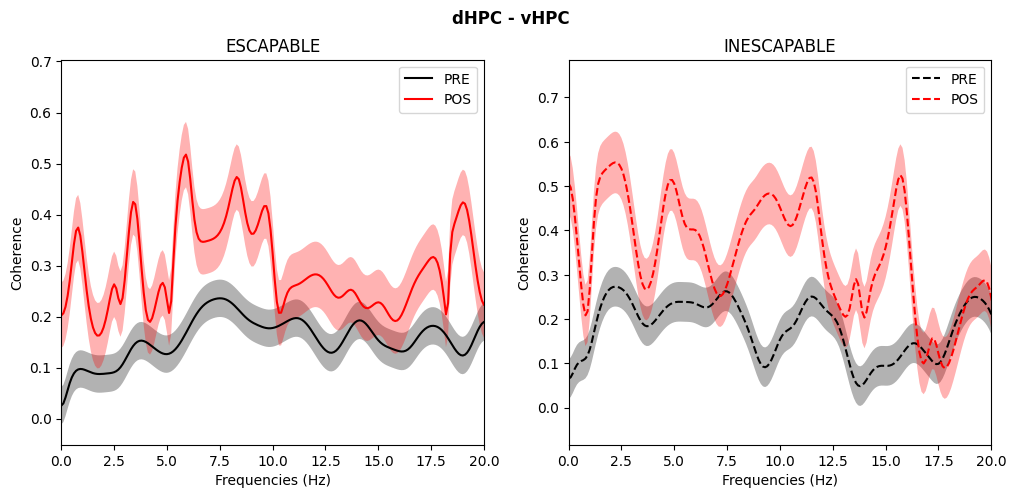

In [ ]:
plt.figure(figsize = (12,5))
plt.suptitle('dHPC - vHPC', fontweight = 'bold')
plt.subplot(1,2,1)
plt.plot(f,mean_coherence_dhpc_vhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_dhpc_vhpc_pre_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_dhpc_vhpc_pre_escap - std, mean_coherence_dhpc_vhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_dhpc_vhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_dhpc_vhpc_pos_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_dhpc_vhpc_pos_escap - std2, mean_coherence_dhpc_vhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)

plt.title( 'ESCAPABLE')
plt.legend()
plt.xlim(0,20)
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.subplot(1,2,2)

plt.plot(f,mean_coherence_dhpc_vhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_dhpc_vhpc_pre_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_dhpc_vhpc_pre_inescap - std3, mean_coherence_dhpc_vhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_dhpc_vhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_dhpc_vhpc_pos_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_dhpc_vhpc_pos_inescap - std4, mean_coherence_dhpc_vhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)


plt.title( 'INESCAPABLE')
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.legend()
plt.xlim(0,20)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/coherence_dhpc_vhpc.jpeg')

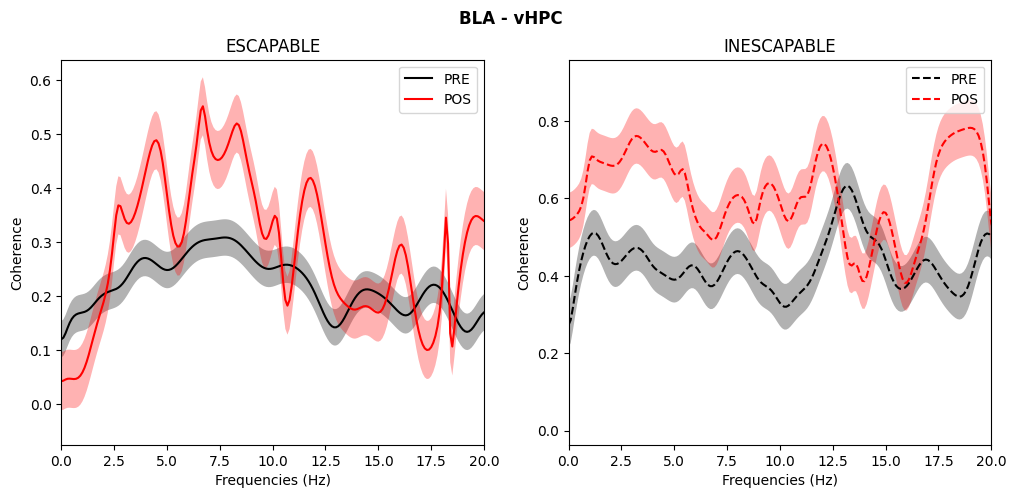

In [ ]:
plt.figure(figsize = (12,5))
plt.suptitle('BLA - vHPC', fontweight = 'bold')
plt.subplot(1,2,1)
plt.plot(f,mean_coherence_bla_vhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_bla_vhpc_pre_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_vhpc_pre_escap - std, mean_coherence_bla_vhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

plt.plot(f,mean_coherence_bla_vhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_bla_vhpc_pos_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_vhpc_pos_escap - std2, mean_coherence_bla_vhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)

plt.title( 'ESCAPABLE')
plt.legend()
plt.xlim(0,20)
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')

plt.subplot(1,2,2)
plt.plot(f,mean_coherence_bla_vhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_bla_vhpc_pre_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_vhpc_pre_inescap - std3, mean_coherence_bla_vhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_bla_vhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_bla_vhpc_pos_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_vhpc_pos_inescap - std4, mean_coherence_bla_vhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

plt.title( 'INESCAPABLE')
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.legend()
plt.xlim(0,20)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/coherence_bla_vhpc.jpeg')

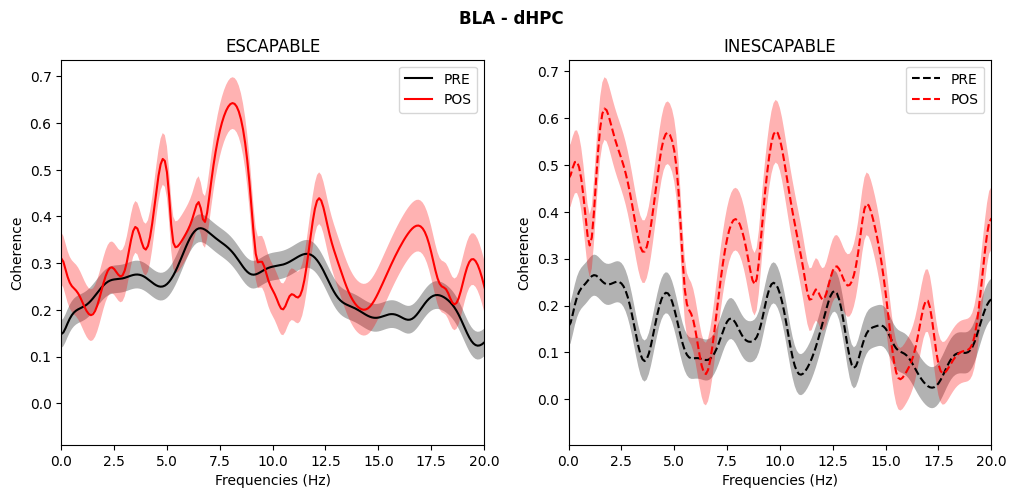

In [ ]:
plt.figure(figsize = (12,5))
plt.suptitle('BLA - dHPC', fontweight = 'bold')
plt.subplot(1,2,1)
plt.plot(f,mean_coherence_bla_dhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_bla_dhpc_pre_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_dhpc_pre_escap - std, mean_coherence_bla_dhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

plt.plot(f,mean_coherence_bla_dhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_bla_dhpc_pos_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_dhpc_pos_escap - std2, mean_coherence_bla_dhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


plt.title( 'ESCAPABLE')
plt.legend()
plt.xlim(0,20)
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')

plt.subplot(1,2,2)
plt.plot(f,mean_coherence_bla_dhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_bla_dhpc_pre_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_dhpc_pre_inescap - std3, mean_coherence_bla_dhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_bla_dhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_bla_dhpc_pos_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_bla_dhpc_pos_inescap - std4, mean_coherence_bla_dhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)


plt.title( 'INESCAPABLE')
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.legend()
plt.xlim(0,20)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/coherence_bla_dhpc.jpeg')

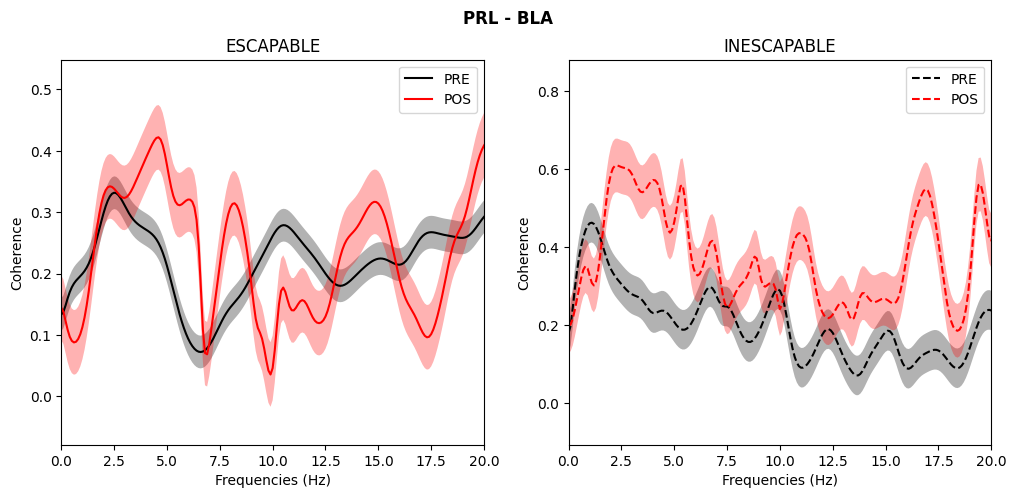

In [ ]:
plt.figure(figsize = (12,5))
plt.suptitle('PRL - BLA ', fontweight = 'bold')
plt.subplot(1,2,1)
plt.plot(f,mean_coherence_prl_bla_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_prl_bla_pre_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_bla_pre_escap - std, mean_coherence_prl_bla_pre_escap + std, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_prl_bla_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_prl_bla_pos_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_bla_pos_escap - std2, mean_coherence_prl_bla_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


plt.title( 'ESCAPABLE')
plt.legend()
plt.xlim(0,20)
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.subplot(1,2,2)
plt.plot(f,mean_coherence_prl_bla_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_prl_bla_pre_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_bla_pre_inescap - std3, mean_coherence_prl_bla_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_prl_bla_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_prl_bla_pos_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_bla_pos_inescap - std4, mean_coherence_prl_bla_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)


plt.title( 'INESCAPABLE')
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.legend()
plt.xlim(0,20)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/coherence_prl_bla.jpeg')

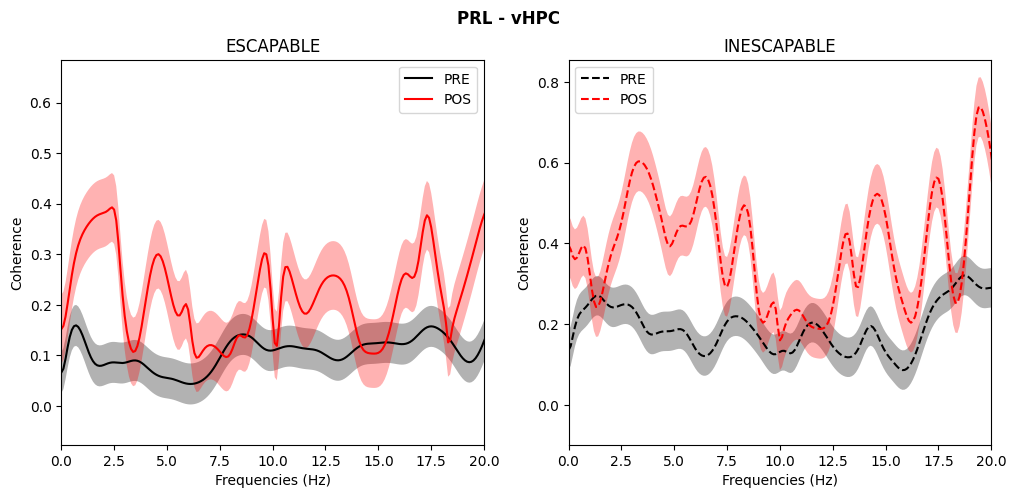

In [ ]:
plt.figure(figsize = (12,5))
plt.suptitle('PRL - vHPC ', fontweight = 'bold')
plt.subplot(1,2,1)
plt.plot(f,mean_coherence_prl_vhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_prl_vhpc_pre_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_vhpc_pre_escap - std, mean_coherence_prl_vhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

plt.plot(f,mean_coherence_prl_vhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_prl_vhpc_pos_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_vhpc_pos_escap - std2, mean_coherence_prl_vhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)

plt.title( 'ESCAPABLE')
plt.legend()
plt.xlim(0,20)
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.subplot(1,2,2)
plt.plot(f,mean_coherence_prl_vhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_prl_vhpc_pre_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_vhpc_pre_inescap - std3, mean_coherence_prl_vhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_prl_vhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_prl_vhpc_pos_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_vhpc_pos_inescap - std4, mean_coherence_prl_vhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

plt.title( 'INESCAPABLE')
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.legend()
plt.xlim(0,20)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/coherence_prl_vhpc.jpeg')

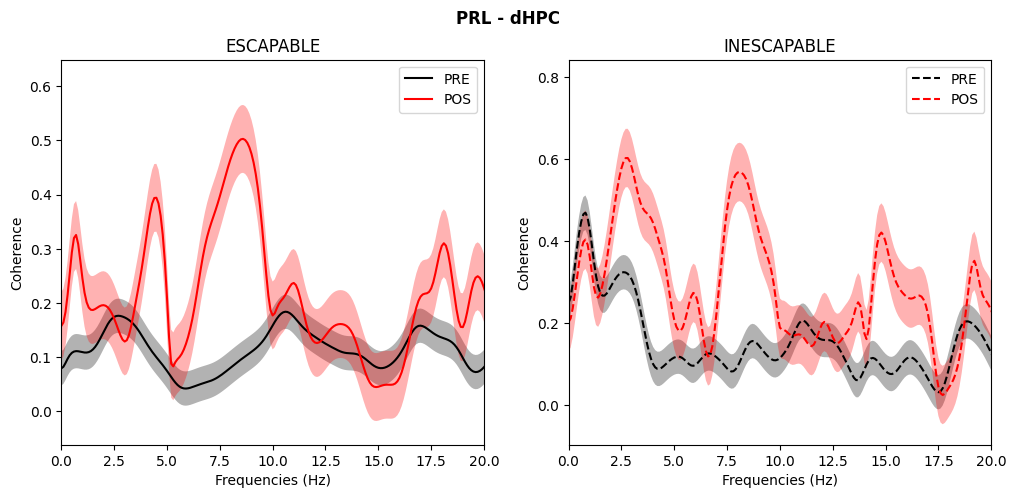

In [ ]:
plt.figure(figsize = (12,5))
plt.suptitle('PRL - dHPC ', fontweight = 'bold')
plt.subplot(1,2,1)
plt.plot(f,mean_coherence_prl_dhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_prl_dhpc_pre_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_dhpc_pre_escap - std, mean_coherence_prl_dhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)


plt.plot(f,mean_coherence_prl_dhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_prl_dhpc_pos_escap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_dhpc_pos_escap - std2, mean_coherence_prl_dhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


plt.title( 'ESCAPABLE')
plt.legend()
plt.xlim(0,20)
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.subplot(1,2,2)
plt.plot(f,mean_coherence_prl_dhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_prl_dhpc_pre_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_dhpc_pre_inescap - std3, mean_coherence_prl_dhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)

plt.plot(f,mean_coherence_prl_dhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_prl_dhpc_pos_inescap)/np.sqrt(3)
plt.fill_between(f, mean_coherence_prl_dhpc_pos_inescap - std4, mean_coherence_prl_dhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

plt.title( 'INESCAPABLE')
plt.ylabel('Coherence')
plt.xlabel('Frequencies (Hz)')
plt.legend()
plt.xlim(0,20)

plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/coherence_prl_dhpc.jpeg')

> # BARPLOT

In [ ]:
media_coherence

,grupo,r1+r2,condicao,f,coherence,banda
0,ESCAPABLE,BLA_dHPC,POS,0.0,0.310195,Delta
1,ESCAPABLE,BLA_dHPC,POS,0.1,0.303087,Delta
2,ESCAPABLE,BLA_dHPC,POS,0.2,0.286966,Delta
3,ESCAPABLE,BLA_dHPC,POS,0.3,0.270592,Delta
4,ESCAPABLE,BLA_dHPC,POS,0.4,0.258480,Delta
...,...,...,...,...,...,...
120019,INESCAPABLE,dHPC_vHPC,PRE,499.6,0.195079,High gamma
120020,INESCAPABLE,dHPC_vHPC,PRE,499.7,0.155016,High gamma
120021,INESCAPABLE,dHPC_vHPC,PRE,499.8,0.111768,High gamma
120022,INESCAPABLE,dHPC_vHPC,PRE,499.9,0.076439,High gamma


In [ ]:
media_coherence['r1+r2'].unique()

array(['BLA_dHPC', 'BLA_vHPC', 'PRL_BLA', 'PRL_dHPC', 'PRL_vHPC',
       'dHPC_vHPC'], dtype=object)

In [ ]:

agrupar= df_coherence_all_animals.groupby(['animal', 'condicao', 'r1+r2', 'banda', 'grupo'])
mean_cohe_animal = agrupar['coherence'].mean().reset_index()

coherence_por_animal = pd.DataFrame(mean_cohe_animal[(mean_cohe_animal['banda'] == 'Theta') ])


<ipython-input-156-b9cea49b9fbf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_BLA_dHPC['condicao'] = pd.Categorical(df_barplot_BLA_dHPC['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-156-b9cea49b9fbf>:16: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


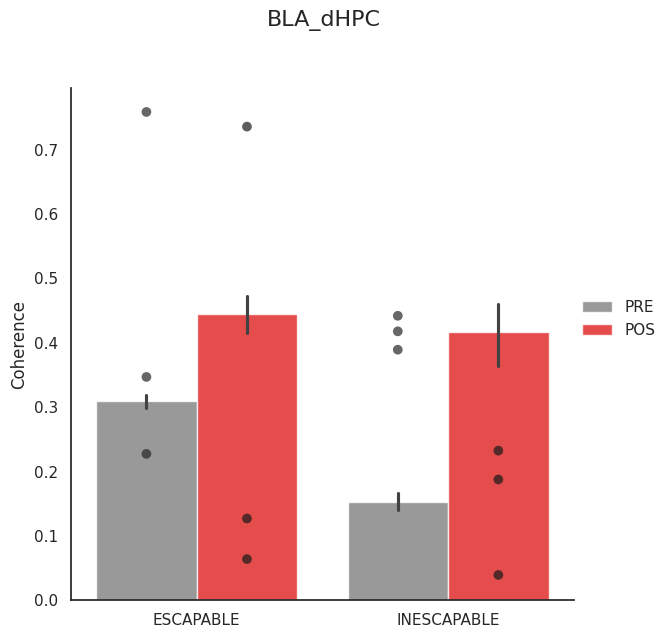

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_BLA_dHPC = media_coherence[(media_coherence['r1+r2'] == 'BLA_dHPC')&(media_coherence['banda'] == 'Theta')]
df_barplot_BLA_dHPC['condicao'] = pd.Categorical(df_barplot_BLA_dHPC['condicao'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_BLA_dHPC, kind="bar",
    x="grupo", y="coherence", hue="condicao",
    errorbar='ci', palette=['grey', 'red'], alpha=0.8, height=6,
)

df_swarmplot_BLA_dHPC = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'BLA_dHPC')]


sns.swarmplot(
    data=df_swarmplot_BLA_dHPC, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)



titulo_principal = plt.suptitle("BLA_dHPC", fontsize=16)
titulo_principal.set_y(1.1)

g.set_axis_labels("", 'Coherence')
g.legend.set_title("")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


> # coherence + barplot

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-258-a6955727df9c>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_BLA_dHPC['condicao'] = pd.Categorical(df_barplot_BLA_dHPC['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-258-a6955727df9c>:84: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swar

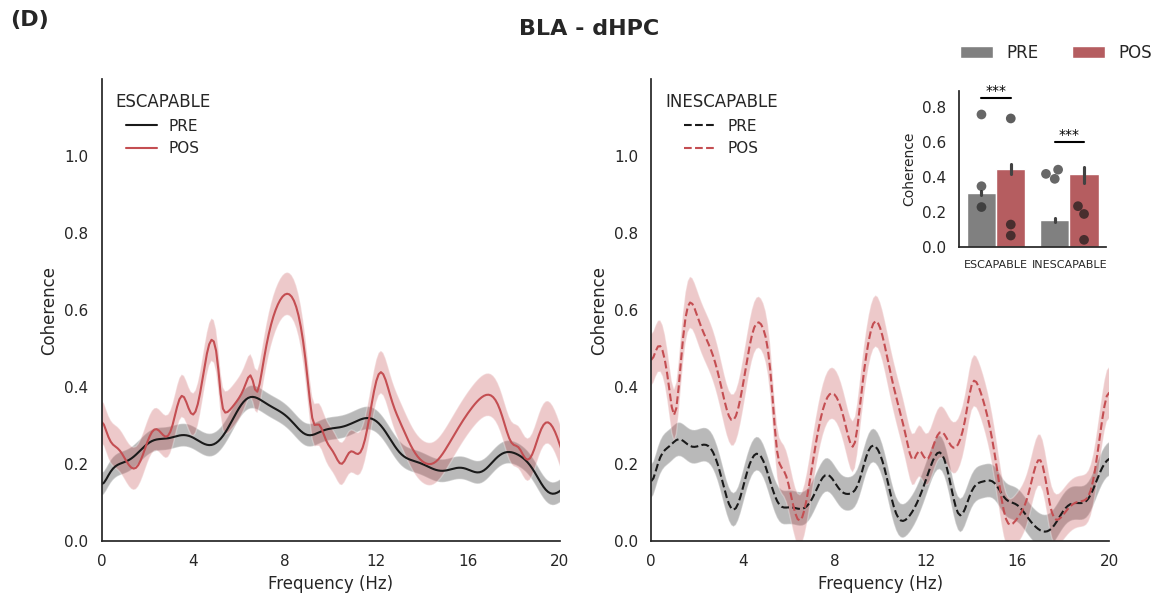

In [ ]:
# BLA_dHPC


fig = plt.figure(figsize=(13, 6))
fig.suptitle('BLA - dHPC', fontsize=16, fontweight = 'bold')
gs = GridSpec(1, 2, figure=fig)

ax_main = fig.add_subplot(gs[0, 0])
ax_inset = fig.add_subplot(gs[0, 1])
ax_main.text(-0.20, 1.15, "(D)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")



ax_main.plot(f,mean_coherence_bla_dhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_bla_dhpc_pre_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_bla_dhpc_pre_escap - std, mean_coherence_bla_dhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

ax_main.plot(f,mean_coherence_bla_dhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_bla_dhpc_pos_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_bla_dhpc_pos_escap - std2, mean_coherence_bla_dhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


ax_main.grid(False)
ax_main.legend(fontsize=11, loc='upper left', frameon=False,  title='ESCAPABLE')
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Coherence')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))
ax_main.set_ylim(0, 1.2)
ax_main.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.set_title('ESCAPABLE', fontweight='bold', pad=8, fontsize=12)

ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)



ax_inset.plot(f,mean_coherence_bla_dhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_bla_dhpc_pre_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_bla_dhpc_pre_inescap - std3, mean_coherence_bla_dhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


ax_inset.plot(f,mean_coherence_bla_dhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_bla_dhpc_pos_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_bla_dhpc_pos_inescap - std4, mean_coherence_bla_dhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

ax_inset.grid(False)
ax_inset.legend(fontsize=11, loc='upper left', frameon=False, title='INESCAPABLE')
ax_inset.set_xlabel('Frequency (Hz)')
ax_inset.set_ylabel('Coherence')
ax_inset.set_xlim(0, 20)
ax_inset.set_xticks(np.arange(0, 21, 4))
ax_inset.set_ylim(0, 1.2)
ax_inset.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax_inset.set_title('INESCAPABLE', fontweight='bold', pad=8, fontsize=12)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)




# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_BLA_dHPC = media_coherence[(media_coherence['r1+r2'] == 'BLA_dHPC')&(media_coherence['banda'] == 'Theta')]
df_barplot_BLA_dHPC['condicao'] = pd.Categorical(df_barplot_BLA_dHPC['condicao'], categories=["PRE", "POS"], ordered=True)

df_swarmplot_BLA_dHPC = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'BLA_dHPC')]

axins = inset_axes(ax_main, width="32%", height="34%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 1., 0.99),  # x0, y0, largura, altura
                   bbox_transform=ax_inset.transAxes)

sns.barplot(data=df_barplot_BLA_dHPC, x="grupo", y="coherence", hue="condicao",
            palette=['grey', 'r'],  ax=axins, legend=True)

axins.axhline(y=0.60 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=0.85 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.text(1,0.62, '***', color='black', fontsize=10, ha='center')
axins.text(0,0.87, '***', color='black', fontsize=10, ha='center')

sns.swarmplot(
    data=df_swarmplot_BLA_dHPC, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)



# titulo_principal = plt.suptitle("BLA_dHPC", fontsize=16)
# titulo_principal.set_y(1.1)


leg = axins.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), fontsize='medium', title='', title_fontsize='small', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Coherence', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='8')
# axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/COHERENCE_BLA_dHPC.jpeg')


plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-257-e678ab4181c1>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_BLA_vHPC['condicao'] = pd.Categorical(df_barplot_BLA_vHPC['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-257-e678ab4181c1>:86: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swar

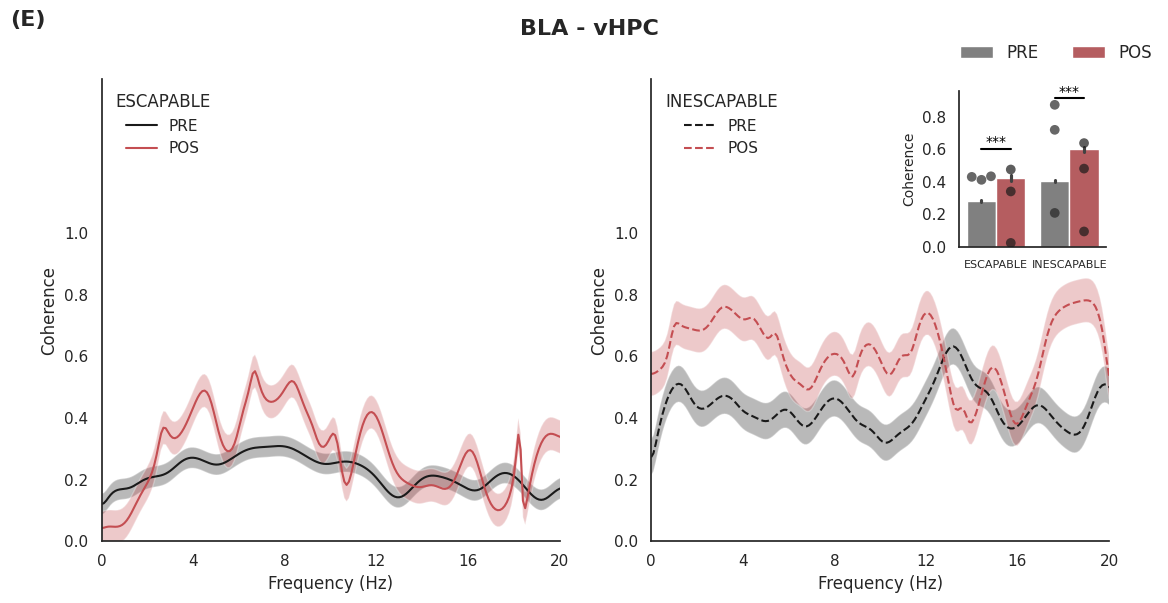

In [ ]:
# BLA_vHPC


fig = plt.figure(figsize=(13, 6))
fig.suptitle('BLA - vHPC', fontsize=16, fontweight = 'bold')
gs = GridSpec(1, 2, figure=fig)

ax_main = fig.add_subplot(gs[0, 0])
ax_inset = fig.add_subplot(gs[0, 1])
ax_main.text(-0.20, 1.15, "(E)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")



ax_main.plot(f,mean_coherence_bla_vhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_bla_vhpc_pre_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_bla_vhpc_pre_escap - std, mean_coherence_bla_vhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

ax_main.plot(f,mean_coherence_bla_vhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_bla_vhpc_pos_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_bla_vhpc_pos_escap - std2, mean_coherence_bla_vhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


ax_main.grid(False)
ax_main.legend(fontsize=11, loc='upper left', frameon=False,  title='ESCAPABLE')
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Coherence')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))

ax_main.set_ylim(0, 1.5)
ax_main.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.set_title('ESCAPABLE', fontweight='bold', pad=8, fontsize=12)

ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)



ax_inset.plot(f,mean_coherence_bla_vhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_bla_vhpc_pre_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_bla_vhpc_pre_inescap - std3, mean_coherence_bla_vhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


ax_inset.plot(f,mean_coherence_bla_vhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_bla_vhpc_pos_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_bla_vhpc_pos_inescap - std4, mean_coherence_bla_vhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

ax_inset.grid(False)
ax_inset.legend(fontsize=11, loc='upper left', frameon=False, title='INESCAPABLE')
ax_inset.set_xlabel('Frequency (Hz)')
ax_inset.set_ylabel('Coherence')
ax_inset.set_xlim(0, 20)
ax_inset.set_xticks(np.arange(0, 21, 4))
ax_inset.set_ylim(0, 1.5)
ax_inset.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax_inset.set_title('INESCAPABLE', fontweight='bold', pad=8, fontsize=12)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)




# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_BLA_vHPC = media_coherence[(media_coherence['r1+r2'] == 'BLA_vHPC')&(media_coherence['banda'] == 'Theta')]
df_barplot_BLA_vHPC['condicao'] = pd.Categorical(df_barplot_BLA_vHPC['condicao'], categories=["PRE", "POS"], ordered=True)

df_swarmplot_BLA_vHPC = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'BLA_vHPC')]

axins = inset_axes(ax_main, width="32%", height="34%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 1., 0.99),  # x0, y0, largura, altura
                   bbox_transform=ax_inset.transAxes)

sns.barplot(data=df_barplot_BLA_vHPC, x="grupo", y="coherence", hue="condicao",
            palette=['grey', 'r'],  ax=axins, legend=True)

axins.axhline(y=0.6 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=0.915 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.text(0,0.62, '***', color='black', fontsize=10, ha='center')
axins.text(1,0.93, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(
    data=df_swarmplot_BLA_vHPC, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)





leg = axins.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), fontsize='medium', title='', title_fontsize='small', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Coherence', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='8')
# axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/COHERENCE_BLA_vHPC.jpeg')


plt.show()

<ipython-input-266-d904a422033d>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_PRL_BLA['condicao'] = pd.Categorical(df_barplot_PRL_BLA['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-266-d904a422033d>:86: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


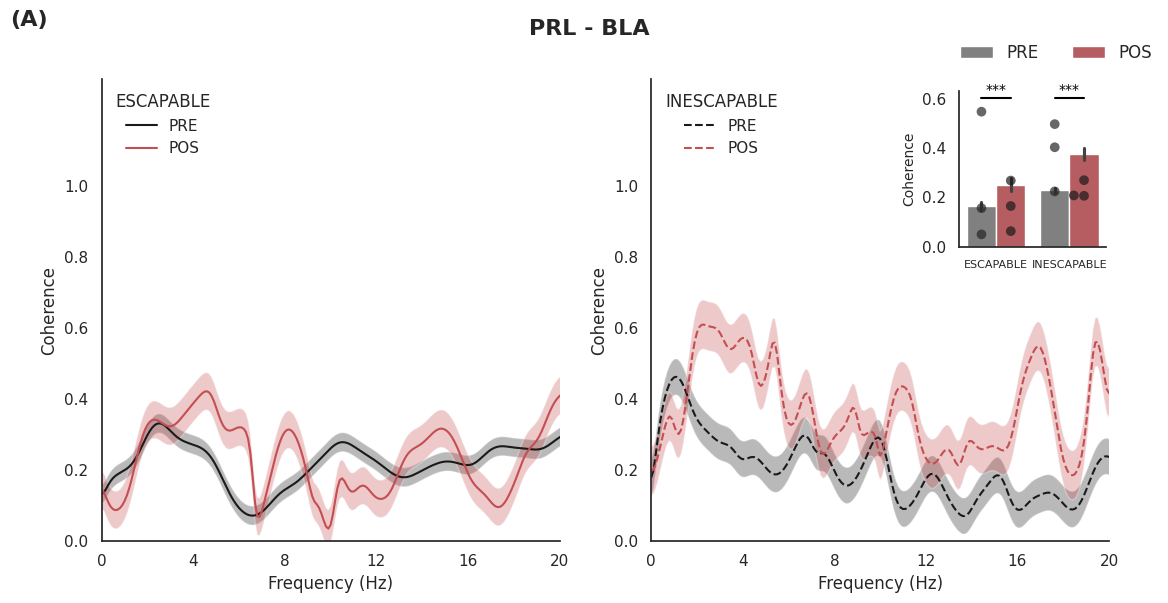

In [ ]:
# PRL_BLA


fig = plt.figure(figsize=(13, 6))
fig.suptitle('PRL - BLA', fontsize=16, fontweight = 'bold')
gs = GridSpec(1, 2, figure=fig)

ax_main = fig.add_subplot(gs[0, 0])
ax_inset = fig.add_subplot(gs[0, 1])
ax_main.text(-0.20, 1.15, "(A)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")



ax_main.plot(f,mean_coherence_prl_bla_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_prl_bla_pre_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_prl_bla_pre_escap - std, mean_coherence_prl_bla_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

ax_main.plot(f,mean_coherence_prl_bla_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_prl_bla_pos_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_prl_bla_pos_escap - std2, mean_coherence_prl_bla_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


ax_main.grid(False)
ax_main.legend(fontsize=11, loc='upper left', frameon=False,  title='ESCAPABLE')
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Coherence')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))

ax_main.set_ylim(0, 1.3)
ax_main.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.set_title('ESCAPABLE', fontweight='bold', pad=8, fontsize=12)

ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)



ax_inset.plot(f,mean_coherence_prl_bla_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_prl_bla_pre_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_prl_bla_pre_inescap - std3, mean_coherence_prl_bla_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


ax_inset.plot(f,mean_coherence_prl_bla_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_prl_bla_pos_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_prl_bla_pos_inescap - std4, mean_coherence_prl_bla_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

ax_inset.grid(False)
ax_inset.legend(fontsize=11, loc='upper left', frameon=False, title='INESCAPABLE')
ax_inset.set_xlabel('Frequency (Hz)')
ax_inset.set_ylabel('Coherence')
ax_inset.set_xlim(0, 20)
ax_inset.set_xticks(np.arange(0, 21, 4))
ax_inset.set_ylim(0, 1.3)
ax_inset.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax_inset.set_title('INESCAPABLE', fontweight='bold', pad=8, fontsize=12)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)




# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_PRL_BLA = media_coherence[(media_coherence['r1+r2'] == 'PRL_BLA')&(media_coherence['banda'] == 'Theta')]
df_barplot_PRL_BLA['condicao'] = pd.Categorical(df_barplot_PRL_BLA['condicao'], categories=["PRE", "POS"], ordered=True)

df_swarmplot_PRL_BLA = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'PRL_BLA')]

axins = inset_axes(ax_main, width="32%", height="34%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 1., 0.99),  # x0, y0, largura, altura
                   bbox_transform=ax_inset.transAxes)

sns.barplot(data=df_barplot_PRL_BLA, x="grupo", y="coherence", hue="condicao",
            palette=['grey', 'r'],  ax=axins, legend=True)

axins.axhline(y=0.6 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=0.6 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.text(0,0.62, '***', color='black', fontsize=10, ha='center')
axins.text(1,0.62, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(
    data=df_swarmplot_PRL_BLA, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)





leg = axins.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), fontsize='medium', title='', title_fontsize='small', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Coherence', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='8')
# axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/COHERENCE_PRL_BLA.jpeg')


plt.show()

<ipython-input-268-d1fe3d43ef6b>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_PRL_dHPC['condicao'] = pd.Categorical(df_barplot_PRL_dHPC['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-268-d1fe3d43ef6b>:86: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


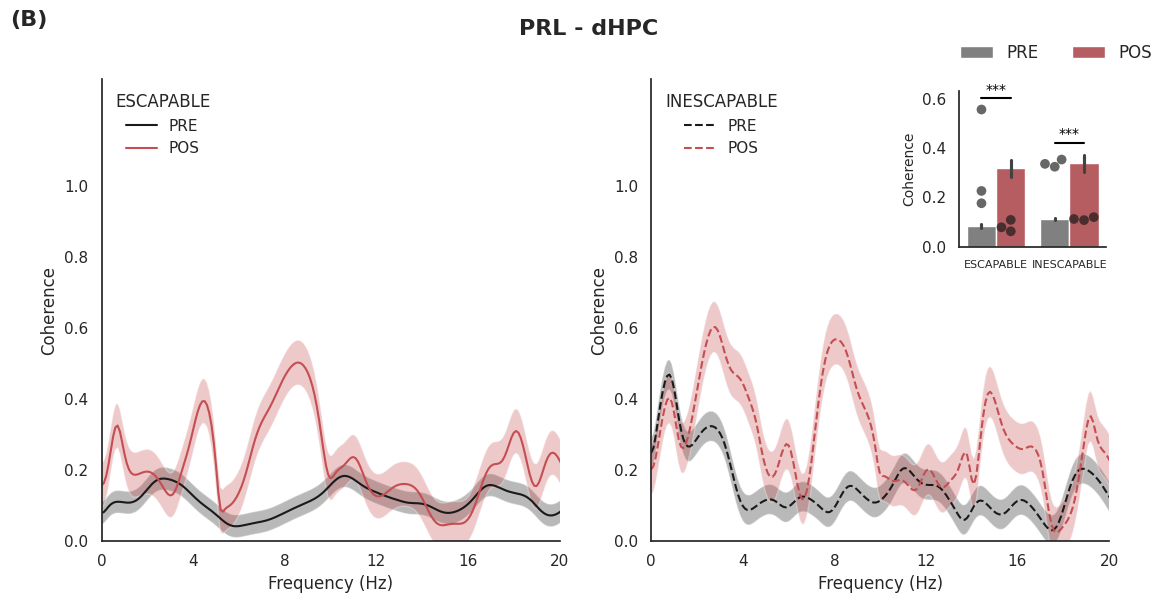

In [ ]:
# PRL_dHPC


fig = plt.figure(figsize=(13, 6))
fig.suptitle('PRL - dHPC', fontsize=16, fontweight = 'bold')
gs = GridSpec(1, 2, figure=fig)

ax_main = fig.add_subplot(gs[0, 0])
ax_inset = fig.add_subplot(gs[0, 1])
ax_main.text(-0.20, 1.15, "(B)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")



ax_main.plot(f,mean_coherence_prl_dhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_prl_dhpc_pre_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_prl_dhpc_pre_escap - std, mean_coherence_prl_dhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

ax_main.plot(f,mean_coherence_prl_dhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_prl_dhpc_pos_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_prl_dhpc_pos_escap - std2, mean_coherence_prl_dhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


ax_main.grid(False)
ax_main.legend(fontsize=11, loc='upper left', frameon=False,  title='ESCAPABLE')
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Coherence')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))

ax_main.set_ylim(0, 1.3)
ax_main.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.set_title('ESCAPABLE', fontweight='bold', pad=8, fontsize=12)

ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)



ax_inset.plot(f,mean_coherence_prl_dhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_prl_dhpc_pre_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_prl_dhpc_pre_inescap - std3, mean_coherence_prl_dhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


ax_inset.plot(f,mean_coherence_prl_dhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_prl_dhpc_pos_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_prl_dhpc_pos_inescap - std4, mean_coherence_prl_dhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

ax_inset.grid(False)
ax_inset.legend(fontsize=11, loc='upper left', frameon=False, title='INESCAPABLE')
ax_inset.set_xlabel('Frequency (Hz)')
ax_inset.set_ylabel('Coherence')
ax_inset.set_xlim(0, 20)
ax_inset.set_xticks(np.arange(0, 21, 4))
ax_inset.set_ylim(0, 1.3)
ax_inset.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax_inset.set_title('INESCAPABLE', fontweight='bold', pad=8, fontsize=12)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)




# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_PRL_dHPC = media_coherence[(media_coherence['r1+r2'] == 'PRL_dHPC')&(media_coherence['banda'] == 'Theta')]
df_barplot_PRL_dHPC['condicao'] = pd.Categorical(df_barplot_PRL_dHPC['condicao'], categories=["PRE", "POS"], ordered=True)

df_swarmplot_PRL_dHPC = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'PRL_dHPC')]

axins = inset_axes(ax_main, width="32%", height="34%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 1., 0.99),  # x0, y0, largura, altura
                   bbox_transform=ax_inset.transAxes)

sns.barplot(data=df_barplot_PRL_dHPC, x="grupo", y="coherence", hue="condicao",
            palette=['grey', 'r'],  ax=axins, legend=True)

axins.axhline(y=0.6 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=0.42 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.text(0,0.62, '***', color='black', fontsize=10, ha='center')
axins.text(1,0.44, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(
    data=df_swarmplot_PRL_dHPC, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)





leg = axins.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), fontsize='medium', title='', title_fontsize='small', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Coherence', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='8')
# axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/COHERENCE_PRL_dHPC.jpeg')


plt.show()

<ipython-input-272-20c3e9e5de49>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_PRL_vHPC['condicao'] = pd.Categorical(df_barplot_PRL_vHPC['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-272-20c3e9e5de49>:86: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


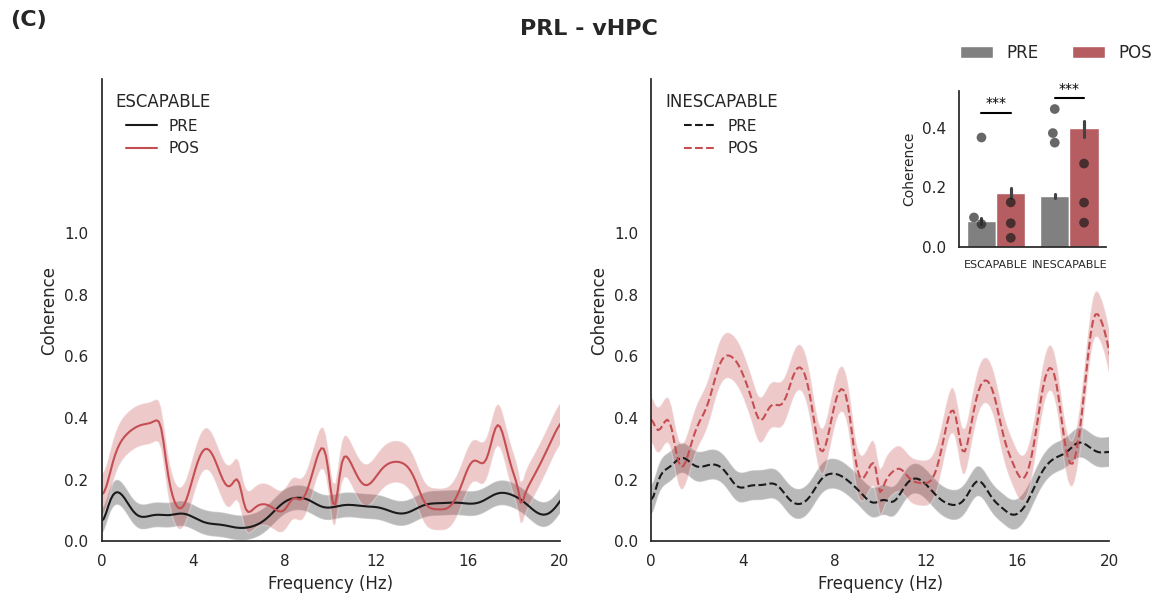

In [ ]:
# PRL_vHPC


fig = plt.figure(figsize=(13, 6))
fig.suptitle('PRL - vHPC', fontsize=16, fontweight = 'bold')
gs = GridSpec(1, 2, figure=fig)

ax_main = fig.add_subplot(gs[0, 0])
ax_inset = fig.add_subplot(gs[0, 1])
ax_main.text(-0.20, 1.15, "(C)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")



ax_main.plot(f,mean_coherence_prl_vhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_prl_vhpc_pre_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_prl_vhpc_pre_escap - std, mean_coherence_prl_vhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

ax_main.plot(f,mean_coherence_prl_vhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_prl_vhpc_pos_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_prl_vhpc_pos_escap - std2, mean_coherence_prl_vhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


ax_main.grid(False)
ax_main.legend(fontsize=11, loc='upper left', frameon=False,  title='ESCAPABLE')
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Coherence')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))

ax_main.set_ylim(0, 1.5)
ax_main.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.set_title('ESCAPABLE', fontweight='bold', pad=8, fontsize=12)

ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)



ax_inset.plot(f,mean_coherence_prl_vhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_prl_vhpc_pre_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_prl_vhpc_pre_inescap - std3, mean_coherence_prl_vhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


ax_inset.plot(f,mean_coherence_prl_vhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_prl_vhpc_pos_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_prl_vhpc_pos_inescap - std4, mean_coherence_prl_vhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

ax_inset.grid(False)
ax_inset.legend(fontsize=11, loc='upper left', frameon=False, title='INESCAPABLE')
ax_inset.set_xlabel('Frequency (Hz)')
ax_inset.set_ylabel('Coherence')
ax_inset.set_xlim(0, 20)
ax_inset.set_xticks(np.arange(0, 21, 4))
ax_inset.set_ylim(0, 1.5)
ax_inset.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax_inset.set_title('INESCAPABLE', fontweight='bold', pad=8, fontsize=12)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)




# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_PRL_vHPC = media_coherence[(media_coherence['r1+r2'] == 'PRL_vHPC')&(media_coherence['banda'] == 'Theta')]
df_barplot_PRL_vHPC['condicao'] = pd.Categorical(df_barplot_PRL_vHPC['condicao'], categories=["PRE", "POS"], ordered=True)

df_swarmplot_PRL_vHPC = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'PRL_vHPC')]

axins = inset_axes(ax_main, width="32%", height="34%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 1., 0.99),  # x0, y0, largura, altura
                   bbox_transform=ax_inset.transAxes)

sns.barplot(data=df_barplot_PRL_vHPC, x="grupo", y="coherence", hue="condicao",
            palette=['grey', 'r'],  ax=axins, legend=True)

axins.axhline(y=0.45 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=0.5 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.text(0,0.47, '***', color='black', fontsize=10, ha='center')
axins.text(1,0.52, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(
    data=df_swarmplot_PRL_vHPC, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)





leg = axins.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), fontsize='medium', title='', title_fontsize='small', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Coherence', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='8')
# axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/COHERENCE_PRL_vHPC.jpeg')


plt.show()

In [ ]:
media_coherence['r1+r2'].unique()

array(['BLA_dHPC', 'BLA_vHPC', 'PRL_BLA', 'PRL_dHPC', 'PRL_vHPC',
       'dHPC_vHPC'], dtype=object)

<ipython-input-276-0a7121df54c0>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_dHPC_vHPC['condicao'] = pd.Categorical(df_barplot_dHPC_vHPC['condicao'], categories=["PRE", "POS"], ordered=True)
<ipython-input-276-0a7121df54c0>:86: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:k'` for the same effect.

  sns.swarmplot(


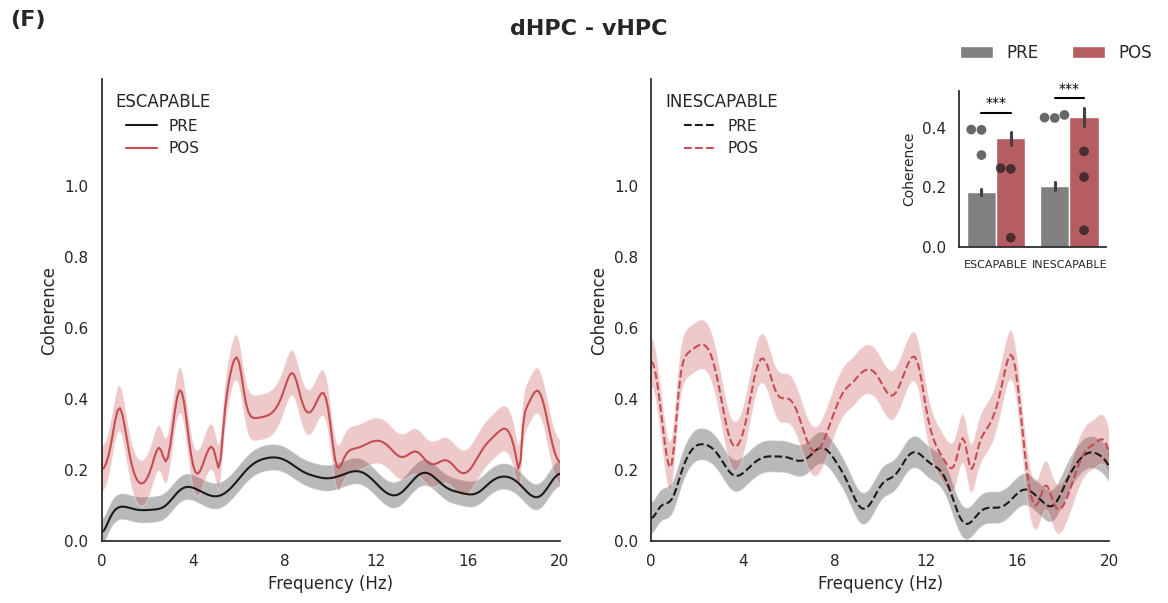

In [ ]:
# dHPC_vHPC


fig = plt.figure(figsize=(13, 6))
fig.suptitle('dHPC - vHPC', fontsize=16, fontweight = 'bold')
gs = GridSpec(1, 2, figure=fig)

ax_main = fig.add_subplot(gs[0, 0])
ax_inset = fig.add_subplot(gs[0, 1])
ax_main.text(-0.20, 1.15, "(F)", transform=ax_main.transAxes, fontsize=16, fontweight="bold", va="top")



ax_main.plot(f,mean_coherence_dhpc_vhpc_pre_escap, color = 'k', label = 'PRE' )
std = np.std(mean_coherence_dhpc_vhpc_pre_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_dhpc_vhpc_pre_escap - std, mean_coherence_dhpc_vhpc_pre_escap + std, color='k', alpha=0.3, edgecolor=None)

ax_main.plot(f,mean_coherence_dhpc_vhpc_pos_escap, color = 'r', label = 'POS')
std2 = np.std(mean_coherence_dhpc_vhpc_pos_escap)/np.sqrt(3)
ax_main.fill_between(f, mean_coherence_dhpc_vhpc_pos_escap - std2, mean_coherence_dhpc_vhpc_pos_escap + std2, color='r', alpha=0.3, edgecolor=None)


ax_main.grid(False)
ax_main.legend(fontsize=11, loc='upper left', frameon=False,  title='ESCAPABLE')
ax_main.set_xlabel('Frequency (Hz)')
ax_main.set_ylabel('Coherence')
ax_main.set_xlim(0, 20)
ax_main.set_xticks(np.arange(0, 21, 4))

ax_main.set_ylim(0, 1.3)
ax_main.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.set_title('ESCAPABLE', fontweight='bold', pad=8, fontsize=12)

ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)



ax_inset.plot(f,mean_coherence_dhpc_vhpc_pre_inescap, linestyle='--',color = 'k', label = 'PRE' )
std3 = np.std(mean_coherence_dhpc_vhpc_pre_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_dhpc_vhpc_pre_inescap - std3, mean_coherence_dhpc_vhpc_pre_inescap + std3, color='k', alpha=0.3, edgecolor=None)


ax_inset.plot(f,mean_coherence_dhpc_vhpc_pos_inescap, linestyle='--',color = 'r', label = 'POS')
std4 = np.std(mean_coherence_dhpc_vhpc_pos_inescap)/np.sqrt(3)
ax_inset.fill_between(f, mean_coherence_dhpc_vhpc_pos_inescap - std4, mean_coherence_dhpc_vhpc_pos_inescap + std4, color='r', alpha=0.3, edgecolor=None)

ax_inset.grid(False)
ax_inset.legend(fontsize=11, loc='upper left', frameon=False, title='INESCAPABLE')
ax_inset.set_xlabel('Frequency (Hz)')
ax_inset.set_ylabel('Coherence')
ax_inset.set_xlim(0, 20)
ax_inset.set_xticks(np.arange(0, 21, 4))
ax_inset.set_ylim(0, 1.3)
ax_inset.set_yticks(np.arange(0, 1.1, 0.2))
# ax_main.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# ax_inset.set_title('INESCAPABLE', fontweight='bold', pad=8, fontsize=12)
ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)




# Inserir subplot no canto superior direito

sns.set_theme(style="white")

df_barplot_dHPC_vHPC = media_coherence[(media_coherence['r1+r2'] == 'dHPC_vHPC')&(media_coherence['banda'] == 'Theta')]
df_barplot_dHPC_vHPC['condicao'] = pd.Categorical(df_barplot_dHPC_vHPC['condicao'], categories=["PRE", "POS"], ordered=True)

df_swarmplot_dHPC_vHPC = coherence_por_animal[(coherence_por_animal['r1+r2'] == 'dHPC_vHPC')]

axins = inset_axes(ax_main, width="32%", height="34%", loc='upper right',
                   bbox_to_anchor=(0.01, 0.001, 1., 0.99),  # x0, y0, largura, altura
                   bbox_transform=ax_inset.transAxes)

sns.barplot(data=df_barplot_dHPC_vHPC, x="grupo", y="coherence", hue="condicao",
            palette=['grey', 'r'],  ax=axins, legend=True)

axins.axhline(y=0.45 ,xmin = 0.15, xmax=0.35 ,color='black', linestyle='-', linewidth=1.5)
axins.axhline(y=0.5 ,xmin = 0.65, xmax=0.85 ,color='black', linestyle='-', linewidth=1.5)
axins.text(0,0.47, '***', color='black', fontsize=10, ha='center')
axins.text(1,0.52, '***', color='black', fontsize=10, ha='center')


sns.swarmplot(
    data=df_swarmplot_dHPC_vHPC, x="grupo", y="coherence", hue="condicao",
    color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
)





leg = axins.legend(loc='upper left', bbox_to_anchor=(-0.1, 1.4), fontsize='medium', title='', title_fontsize='small', ncol=2)
leg.set_frame_on(False)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.set_ylabel('Coherence', fontsize = 10)
axins.set_xlabel('')
axins.tick_params(axis='x', labelsize='8')
# axins.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
# plt.tight_layout()
plt.savefig('/content/drive/MyDrive/figuras defesa mestrado/COHERENCE_dHPC_vHPC.jpeg')


plt.show()

> # STATS

In [ ]:
media_coherence

,grupo,r1+r2,condicao,f,coherence,banda
0,ESCAPABLE,BLA_dHPC,POS,0.0,0.310195,Delta
1,ESCAPABLE,BLA_dHPC,POS,0.1,0.303087,Delta
2,ESCAPABLE,BLA_dHPC,POS,0.2,0.286966,Delta
3,ESCAPABLE,BLA_dHPC,POS,0.3,0.270592,Delta
4,ESCAPABLE,BLA_dHPC,POS,0.4,0.258480,Delta
...,...,...,...,...,...,...
120019,INESCAPABLE,dHPC_vHPC,PRE,499.6,0.195079,High gamma
120020,INESCAPABLE,dHPC_vHPC,PRE,499.7,0.155016,High gamma
120021,INESCAPABLE,dHPC_vHPC,PRE,499.8,0.111768,High gamma
120022,INESCAPABLE,dHPC_vHPC,PRE,499.9,0.076439,High gamma


In [ ]:
media_coherence['r1+r2'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['BLA_dHPC', 'BLA_vHPC', 'PRL_BLA', 'PRL_dHPC', 'PRL_vHPC',
       'dHPC_vHPC'], dtype=object)

In [ ]:
A = media_coherence[(media_coherence['r1+r2']=='dHPC_vHPC') &(media_coherence['banda']=='Theta') & (media_coherence['condicao']=='PRE')&(media_coherence['grupo']=='ESCAPABLE')]['coherence']
B = media_coherence[(media_coherence['r1+r2']=='dHPC_vHPC') &(media_coherence['banda']=='Theta') & (media_coherence['condicao']=='POS')&(media_coherence['grupo']=='ESCAPABLE')]['coherence']

C = media_coherence[(media_coherence['r1+r2']=='dHPC_vHPC') &(media_coherence['banda']=='Theta') & (media_coherence['condicao']=='PRE')&(media_coherence['grupo']=='INESCAPABLE')]['coherence']
D = media_coherence[(media_coherence['r1+r2']=='dHPC_vHPC') &(media_coherence['banda']=='Theta') & (media_coherence['condicao']=='POS')&(media_coherence['grupo']=='INESCAPABLE')]['coherence']


In [ ]:
t_stat, p_valor = stats.ttest_rel(A, B)

print(f"T-statistic: {t_stat}, P-value: {p_valor}")

T-statistic: -18.606029610129447, P-value: 2.3015603783490266e-26


In [ ]:
t_stat, p_valor = stats.ttest_rel(C, D)

print(f"T-statistic: {t_stat}, P-value: {p_valor}")

T-statistic: -12.206061171316142, P-value: 8.756897597300255e-18


In [ ]:
t_stat, p_valor = stats.ttest_ind(B, D)

print(f"T-statistic: {t_stat}, P-value: {p_valor}")

T-statistic: -3.9209585224068326, P-value: 0.00014849385899873803


In [ ]:

RESULTADOS_COHERENCE = { 'BLA_dHPC': { 'PRExPOS_ESCAP' : 'T-statistic: -9.033506544852488, P-value: 1.0045916350960282e-12' ,
                                    'PRExPOS_INESCAP': 'T-statistic: -13.679213727344594, P-value: 5.93230964441785e-20',
                                    'POS_ESCAPxINESCAP': 'T-statistic: 0.987524994833706, P-value: 0.32540593707133625'},
                          'BLA_vHPC': { 'PRExPOS_ESCAP': 'T-statistic: -17.78403090027285, P-value: 2.225507519629289e-25',
                                        'PRExPOS_INESCAP': 'T-statistic: -20.760279527462185, P-value: 8.340589664575257e-29',
                                        'POS_ESCAPxINESCAP': 'T-statistic: -13.321471746074904, P-value: 2.8502213513619565e-25' },
                          'PRL_BLA': { 'PRExPOS_ESCAP':'T-statistic: -5.368612435812069, P-value: 1.4024960896843027e-06',
                                        'PRExPOS_INESCAP': 'T-statistic: -10.534238205701675, P-value: 3.5292892708947642e-15',
                                        'POS_ESCAPxINESCAP': 'T-statistic: -6.403902297900524, P-value: 3.2098658243779165e-09'      },

                          'PRL_dHPC': { 'PRExPOS_ESCAP': 'T-statistic: -14.62660856649917, P-value: 2.766182284791941e-21',
                                        'PRExPOS_INESCAP': 'T-statistic: -12.437067297998905, P-value: 3.928475737198178e-18',
                                        'POS_ESCAPxINESCAP':  ' T-statistic: -0.7376992915230878, P-value: 0.46216167117140106'    },
                          'PRL_vHPC': { 'PRExPOS_ESCAP': 'T-statistic: -8.915163267040233, P-value: 1.5823537537972263e-12',
                                        'PRExPOS_INESCAP':'T-statistic: -15.702162788195938, P-value: 9.759964576860006e-23',
                                        'POS_ESCAPxINESCAP': 'T-statistic: -12.978566852454035, P-value: 1.7932367145419683e-24'      },
                          'dHPC_vHPC': { 'PRExPOS_ESCAP': 'T-statistic: -18.606029610129447, P-value: 2.3015603783490266e-26',
                                        'PRExPOS_INESCAP':'T-statistic: -12.206061171316142, P-value: 8.756897597300255e-18',
                                        'POS_ESCAPxINESCAP':' T-statistic: -3.9209585224068326, P-value: 0.00014849385899873803'     }}


In [ ]:

agrupar_escap = df_coherence_all_animals[df_coherence_all_animals['grupo']=='ESCAPABLE'].groupby(['animal',  'condicao', 'r1+r2', 'banda'])

#  média para cada animal de cada grupo
mean_cohe_animal_escap = agrupar_escap['coherence'].mean().reset_index()
mean_cohe_animal_escap['grupo'] = 'ESCAPABLE'
coherence_theta_por_animal_escap = pd.DataFrame(mean_cohe_animal_escap[(mean_cohe_animal_escap['banda'] == 'Theta') ])


agrupar_inescap = df_coherence_all_animals[df_coherence_all_animals['grupo']=='INESCAPABLE'].groupby(['animal',  'condicao', 'r1+r2', 'banda'])

#  média para cada animal de cada grupo
mean_cohe_animal_inescap = agrupar_inescap['coherence'].mean().reset_index()
mean_cohe_animal_inescap['grupo'] = 'INESCAPABLE'
coherence_theta_por_animal_inescap = pd.DataFrame(mean_cohe_animal_inescap[(mean_cohe_animal_inescap['banda'] == 'Theta') ])


coherence_theta_por_animal = pd.concat([coherence_theta_por_animal_escap,coherence_theta_por_animal_inescap])

In [ ]:
coherence_theta_por_animal['r1+r2'].unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['BLA_dHPC', 'BLA_vHPC', 'PRL_BLA', 'PRL_dHPC', 'PRL_vHPC',
       'dHPC_vHPC'], dtype=object)

> # HEATMAP

In [ ]:
# não utilizei essa parte pois não deu certo o resultado!

In [ ]:
df_coherence_all_animals

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

,coherence,f,animal,condicao,grupo,r1,r2,r1+r2,banda,indice
0,0.090873,0.0,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,0
1,0.102299,0.1,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,1
2,0.129618,0.2,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,2
3,0.159923,0.3,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,3
4,0.184857,0.4,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,4
...,...,...,...,...,...,...,...,...,...,...
4996,0.372818,499.6,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4996
4997,0.375151,499.7,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4997
4998,0.376763,499.8,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4998
4999,0.377711,499.9,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4999


In [ ]:
def media_coherence(df, condicao, r1, r2, grupo):
    filtro = (df['condicao'] == condicao) & (df['grupo'] == grupo)& (df['r1'] == r1) & (df['r2'] == r2)
    media_coherence = df[filtro].groupby('indice')['coherence'].mean()
    result_df = pd.DataFrame({'coherence': media_coherence,'r1': r1,'r2': r2,'condicao': condicao, 'regioes': str(r1)+'->'+str(r2), 'grupo': grupo})
    return (result_df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
cohe_prl_bla_pre_escap = media_coherence(  df_coherence_all_animals,'PRE', 'PRL', 'BLA', 'ESCAPABLE' )
cohe_prl_bla_pos_escap = media_coherence(  df_coherence_all_animals,'POS', 'PRL', 'BLA', 'ESCAPABLE' )
cohe_prl_dHPC_pre_escap = media_coherence(  df_coherence_all_animals,'PRE', 'PRL', 'dHPC', 'ESCAPABLE' )
cohe_prl_dHPC_pos_escap = media_coherence(  df_coherence_all_animals,'POS', 'PRL', 'dHPC' , 'ESCAPABLE')
cohe_prl_vHPC_pre_escap = media_coherence(  df_coherence_all_animals,'PRE', 'PRL', 'vHPC', 'ESCAPABLE')
cohe_prl_vHPC_pos_escap = media_coherence(  df_coherence_all_animals,'POS', 'PRL', 'vHPC' , 'ESCAPABLE')

cohe_bla_dHPC_pre_escap = media_coherence(  df_coherence_all_animals,'PRE', 'BLA', 'dHPC', 'ESCAPABLE')
cohe_bla_dHPC_pos_escap = media_coherence(  df_coherence_all_animals,'POS', 'BLA', 'dHPC' , 'ESCAPABLE')

cohe_bla_vHPC_pre_escap = media_coherence(  df_coherence_all_animals,'PRE', 'BLA', 'vHPC', 'ESCAPABLE')
cohe_bla_vHPC_pos_escap = media_coherence(  df_coherence_all_animals,'POS', 'BLA', 'vHPC', 'ESCAPABLE' )

cohe_dHPC_vHPC_pre_escap = media_coherence(  df_coherence_all_animals,'PRE', 'dHPC', 'vHPC', 'ESCAPABLE')
cohe_dHPC_vHPC_pos_escap = media_coherence(  df_coherence_all_animals,'POS', 'dHPC', 'vHPC', 'ESCAPABLE' )

cohe_prl_bla_pre_inescap = media_coherence(  df_coherence_all_animals,'PRE', 'PRL', 'BLA', 'INESCAPABLE' )
cohe_prl_bla_pos_inescap = media_coherence(  df_coherence_all_animals,'POS', 'PRL', 'BLA' , 'INESCAPABLE')
cohe_prl_dHPC_pre_inescap = media_coherence(  df_coherence_all_animals,'PRE', 'PRL', 'dHPC', 'INESCAPABLE' )
cohe_prl_dHPC_pos_inescap = media_coherence(  df_coherence_all_animals,'POS', 'PRL', 'dHPC', 'INESCAPABLE' )
cohe_prl_vHPC_pre_inescap = media_coherence(  df_coherence_all_animals,'PRE', 'PRL', 'vHPC', 'INESCAPABLE')
cohe_prl_vHPC_pos_inescap = media_coherence(  df_coherence_all_animals,'POS', 'PRL', 'vHPC' , 'INESCAPABLE')

cohe_bla_dHPC_pre_inescap = media_coherence(  df_coherence_all_animals,'PRE', 'BLA', 'dHPC', 'INESCAPABLE')
cohe_bla_dHPC_pos_inescap = media_coherence(  df_coherence_all_animals,'POS', 'BLA', 'dHPC', 'INESCAPABLE' )

cohe_bla_vHPC_pre_inescap = media_coherence(  df_coherence_all_animals,'PRE', 'BLA', 'vHPC', 'INESCAPABLE')
cohe_bla_vHPC_pos_inescap = media_coherence(  df_coherence_all_animals,'POS', 'BLA', 'vHPC' , 'INESCAPABLE')

cohe_dHPC_vHPC_pre_inescap = media_coherence(  df_coherence_all_animals,'PRE', 'dHPC', 'vHPC', 'INESCAPABLE')
cohe_dHPC_vHPC_pos_inescap = media_coherence(  df_coherence_all_animals,'POS', 'dHPC', 'vHPC', 'INESCAPABLE' )

In [ ]:
result_coh = pd.concat([cohe_prl_bla_pre_escap, cohe_prl_bla_pos_escap, cohe_prl_dHPC_pre_escap, cohe_prl_dHPC_pos_escap,
                        cohe_prl_vHPC_pre_escap, cohe_prl_vHPC_pos_escap, cohe_bla_dHPC_pre_escap, cohe_bla_dHPC_pos_escap,
                        cohe_bla_vHPC_pre_escap, cohe_bla_vHPC_pos_escap, cohe_dHPC_vHPC_pre_escap, cohe_dHPC_vHPC_pos_escap,
                        cohe_prl_bla_pre_inescap, cohe_prl_bla_pos_inescap, cohe_prl_dHPC_pre_inescap, cohe_prl_dHPC_pos_inescap,
                        cohe_prl_vHPC_pre_inescap, cohe_prl_vHPC_pos_inescap, cohe_bla_dHPC_pre_inescap, cohe_bla_dHPC_pos_inescap,
                        cohe_bla_vHPC_pre_inescap, cohe_bla_vHPC_pos_inescap, cohe_dHPC_vHPC_pre_inescap, cohe_dHPC_vHPC_pos_inescap], axis=0 )


result_coh['frequencia'] = result_coh.index


# Criando nova coluna 'banda' usando a função apply()
result_coh['banda'] = result_coh['frequencia'].apply(mapear_banda)

coh = result_coh.drop(columns='frequencia')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

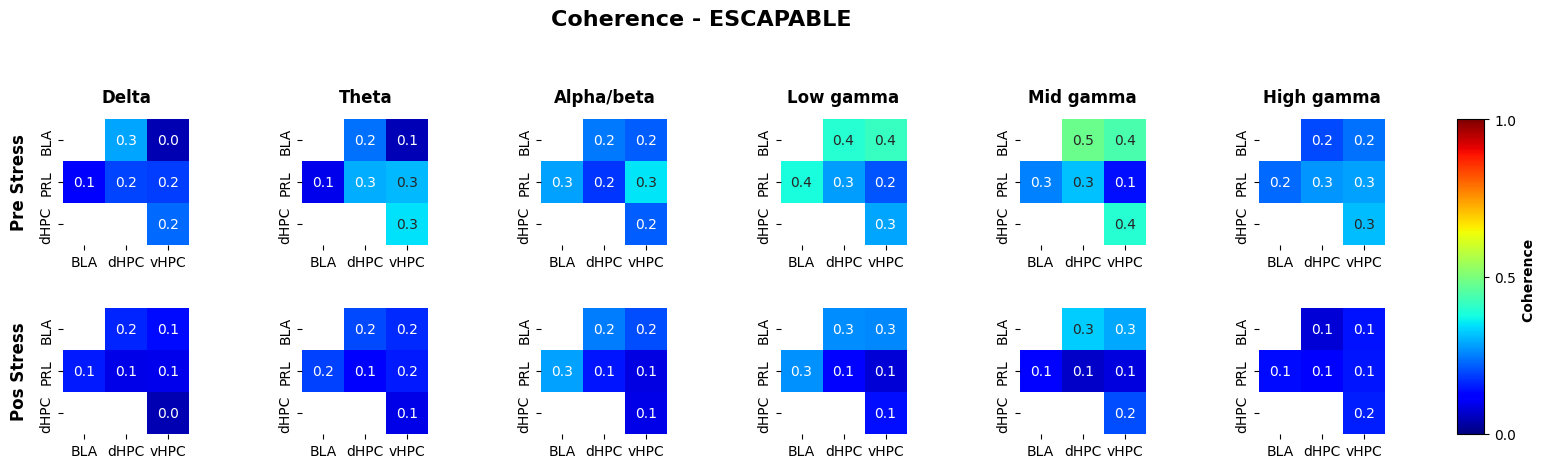

In [ ]:


canais = ['PRL', 'BLA', 'dHPC', 'vHPC']
bandas_coh = ['Delta', 'Theta', 'Alpha/beta', 'Low gamma', 'Mid gamma', 'High gamma']


f, axs = plt.subplots(2, 6, figsize=(18, 5), gridspec_kw={'hspace': 0.5})
plt.suptitle('Coherence - ESCAPABLE', fontsize=16, fontweight='bold', y=1.1, x=0.5)

for banda in range(len(bandas_coh)):
    pre = coh[(coh.banda == bandas_coh[banda]) & (coh.condicao == 'PRE') & (coh.grupo == 'ESCAPABLE')]
    pos = coh[(coh.banda == bandas_coh[banda]) & (coh.condicao == 'POS') & (coh.grupo == 'ESCAPABLE')]

    pivot_pre = pre.pivot_table(index='r1', columns='r2', values='coherence')
    pivot_pos = pos.pivot_table(index='r1', columns='r2', values='coherence')

    sns.heatmap(pivot_pre, vmin=0, vmax=1.0, ax=axs[1, banda], square=True, annot=True, cmap='jet', robust=True,fmt=".1f", cbar=False)
    sns.heatmap(pivot_pos, vmin=0, vmax=1.0, ax=axs[0, banda], square=True, annot=True, cmap='jet', robust=True,fmt=".1f", cbar=False)

    axs[0, banda].set_title(bandas_coh[banda], fontweight='bold', pad=12, fontsize=12)
    axs[1, banda].set_title(None)
    axs[0, banda].set_ylabel(None)
    axs[0, banda].set_xlabel(None)
    axs[1, banda].set_xlabel(None)
    axs[1, banda].set_ylabel(None)



plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')

f.subplots_adjust(bottom=0.25, right=0.9)
cax = f.add_axes([0.92, 0.25, 0.015, 0.63])  # Posição e tamanho da colorbar
cb = mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.jet, norm=mpl.colors.Normalize(vmin=0, vmax=1), orientation='vertical', ticks=[0, 0.5, 1])
cb.set_label('Coherence ', fontweight='bold')





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


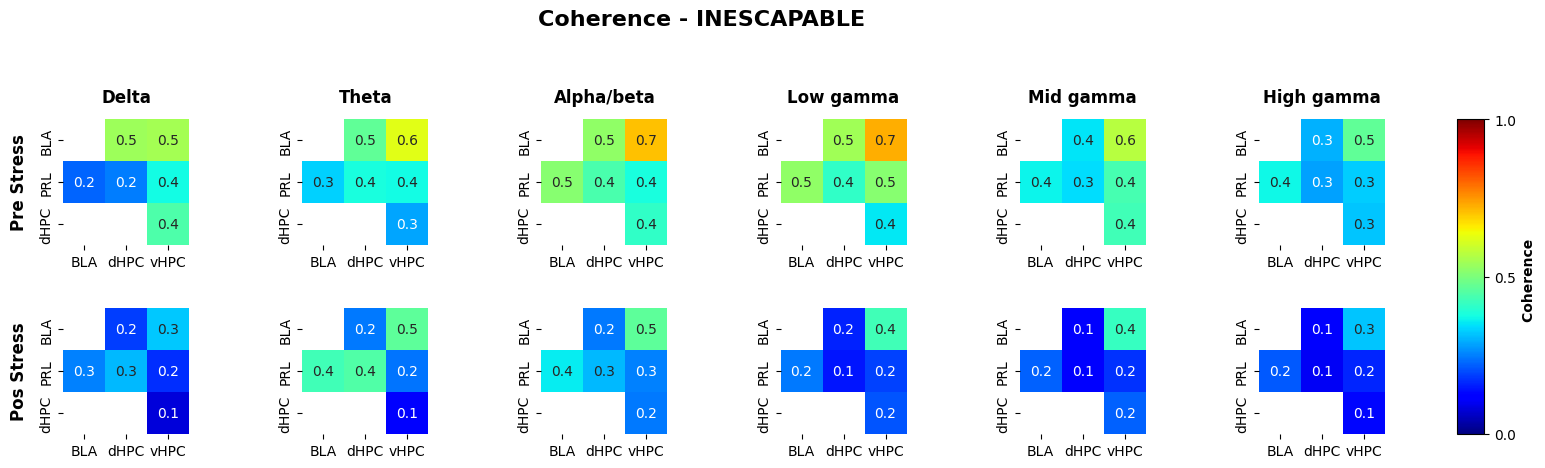

In [ ]:

canais = ['PRL', 'BLA', 'dHPC', 'vHPC']
bandas_coh = ['Delta', 'Theta', 'Alpha/beta', 'Low gamma', 'Mid gamma', 'High gamma']


f, axs = plt.subplots(2, 6, figsize=(18, 5), gridspec_kw={'hspace': 0.5})
plt.suptitle('Coherence - INESCAPABLE', fontsize=16, fontweight='bold', y=1.1, x=0.5)

for banda in range(len(bandas_coh)):
    pre = coh[(coh.banda == bandas_coh[banda]) & (coh.condicao == 'PRE') & (coh.grupo == 'INESCAPABLE')]
    pos = coh[(coh.banda == bandas_coh[banda]) & (coh.condicao == 'POS') & (coh.grupo == 'INESCAPABLE')]

    pivot_pre = pre.pivot_table(index='r1', columns='r2', values='coherence')
    pivot_pos = pos.pivot_table(index='r1', columns='r2', values='coherence')

    sns.heatmap(pivot_pre, vmin=0, vmax=1.0, ax=axs[1, banda], square=True, annot=True, cmap='jet', fmt=".1f", robust=True, cbar=False)
    sns.heatmap(pivot_pos, vmin=0, vmax=1.0, ax=axs[0, banda], square=True, annot=True, cmap='jet', fmt=".1f", robust=True,cbar=False)

    axs[0, banda].set_title(bandas_coh[banda], fontweight='bold', pad=12, fontsize=12)
    axs[1, banda].set_title(None)
    axs[0, banda].set_ylabel(None)
    axs[0, banda].set_xlabel(None)
    axs[1, banda].set_xlabel(None)
    axs[1, banda].set_ylabel(None)



plt.text(-0.35, 0.5, 'Pre Stress', fontsize=12, fontweight='bold', transform=axs[0, 0].transAxes, ha='center', va='center', rotation='vertical')
plt.text(-0.35, 0.5, 'Pos Stress', fontsize=12, fontweight='bold', transform=axs[1, 0].transAxes, ha='center', va='center', rotation='vertical')

f.subplots_adjust(bottom=0.25, right=0.9)
cax = f.add_axes([0.92, 0.25, 0.015, 0.63])
cb = mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.jet, norm=mpl.colors.Normalize(vmin=0, vmax=1), orientation='vertical', ticks=[0, 0.5, 1])
cb.set_label('Coherence ', fontweight='bold')

> # BARPLOT

In [ ]:
df_coherence_all_animals

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,coherence,f,animal,condicao,grupo,r1,r2,r1+r2,banda,indice
0,0.090873,0.0,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,0
1,0.102299,0.1,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,1
2,0.129618,0.2,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,2
3,0.159923,0.3,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,3
4,0.184857,0.4,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Delta,4
...,...,...,...,...,...,...,...,...,...,...
4996,0.372818,499.6,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4996
4997,0.375151,499.7,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4997
4998,0.376763,499.8,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4998
4999,0.377711,499.9,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,High gamma,4999


In [ ]:
# FAZENDO O DF COM A MEDIA COHERENCE DE CADA ANIMAL para o barplot



agrupar = df_coherence_all_animals.groupby([ 'animal','condicao',  'banda', 'r1+r2', 'grupo'])


mean_coh_animal_escap = agrupar['coherence'].mean().reset_index()

coh_theta_por_animal = pd.DataFrame(mean_coh_animal_escap[(mean_coh_animal_escap['banda'] == 'Theta') ])



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-59-feb68c770691>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)


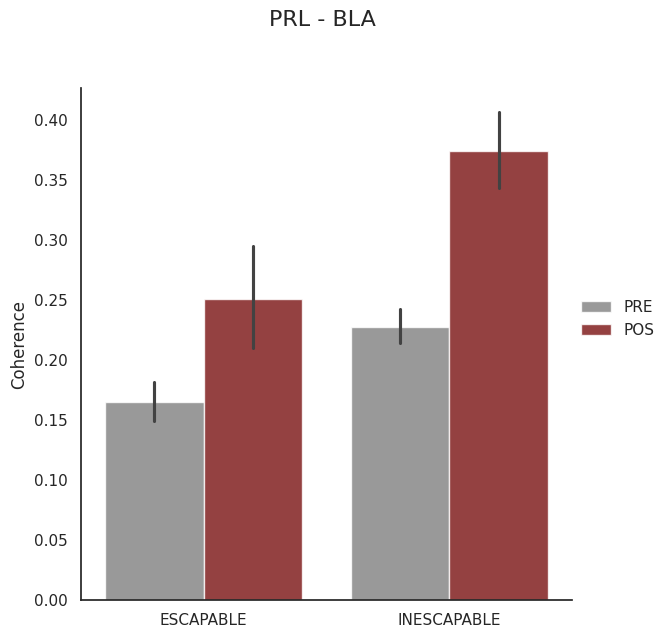

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta = df_coherence_all_animals[(df_coherence_all_animals['banda'] == 'Theta') &(df_coherence_all_animals['r1+r2'] == 'PRL_BLA')]
df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_theta, kind="bar",
    x="grupo", y="coherence", hue="condicao",
    errorbar='ci', palette=['grey', 'darkred'], alpha=0.8, height=6,
)

# df_swarmplot_theta_PRL_BLA = coh_theta_por_animal[(coh_theta_por_animal['r1+r2'] == 'PRL_BLA')]


# sns.swarmplot(
#     data=df_swarmplot_theta_PRL_BLA, x="grupo", y="coherence", hue="condicao",
#     color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
# )



# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("PRL - BLA", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)

# sns.despine(bottom=True)
g.set_axis_labels("", 'Coherence')
g.legend.set_title("")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-60-df39620f8a4e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)


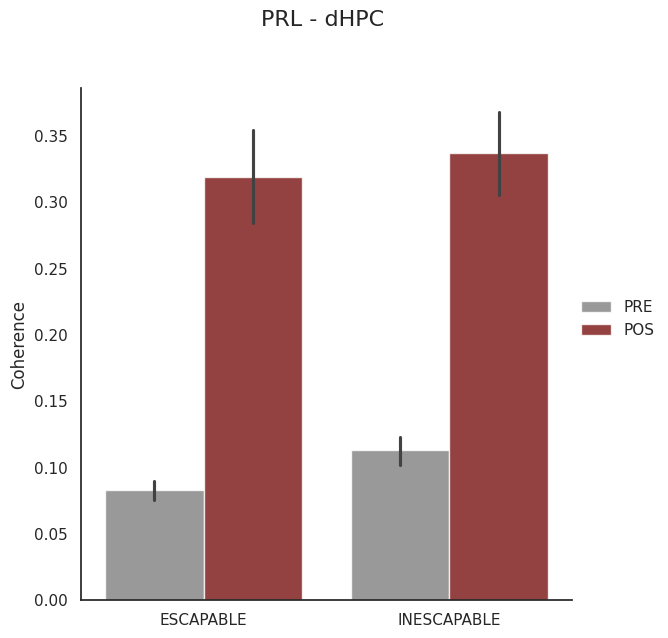

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta = df_coherence_all_animals[(df_coherence_all_animals['banda'] == 'Theta') &(df_coherence_all_animals['r1+r2'] == 'PRL_dHPC')]
df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_theta, kind="bar",
    x="grupo", y="coherence", hue="condicao",
    errorbar='ci', palette=['grey', 'darkred'], alpha=0.8, height=6,
)

# df_swarmplot_theta_PRL_dHPC = coh_theta_por_animal[(coh_theta_por_animal['r1+r2'] == 'PRL_dHPC')]


# sns.swarmplot(
#     data=df_swarmplot_theta_PRL_dHPC, x="grupo", y="coherence", hue="condicao",
#     color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
# )



# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("PRL - dHPC", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)

# sns.despine(bottom=True)
g.set_axis_labels("", 'Coherence')
g.legend.set_title("")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-61-78a9d3a3ee59>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)


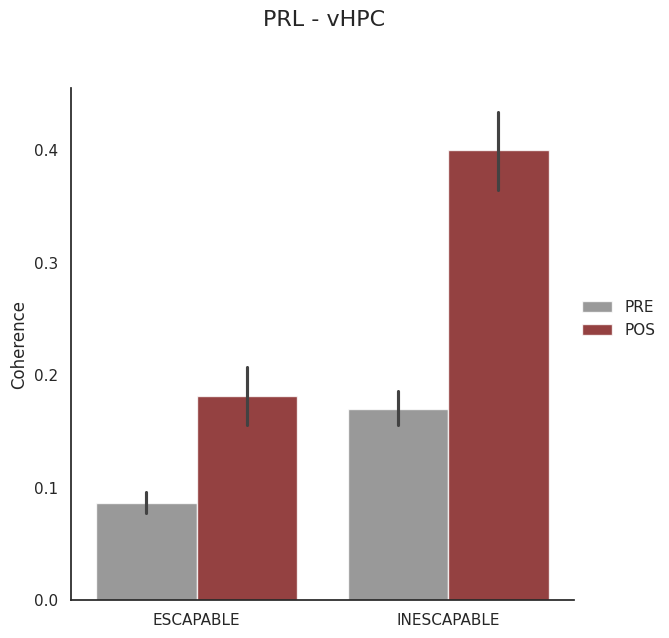

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta = df_coherence_all_animals[(df_coherence_all_animals['banda'] == 'Theta') &(df_coherence_all_animals['r1+r2'] == 'PRL_vHPC')]
df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_theta, kind="bar",
    x="grupo", y="coherence", hue="condicao",
    errorbar='ci', palette=['grey', 'darkred'], alpha=0.8, height=6,
)

# df_swarmplot_theta_PRL_vHPC = coh_theta_por_animal[(coh_theta_por_animal['r1+r2'] == 'PRL_vHPC')]


# sns.swarmplot(
#     data=df_swarmplot_theta_PRL_dHPC, x="grupo", y="coherence", hue="condicao",
#     color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
# )




# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("PRL - vHPC", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)

# sns.despine(bottom=True)
g.set_axis_labels("", 'Coherence')
g.legend.set_title("")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-62-7b8f7751d449>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)


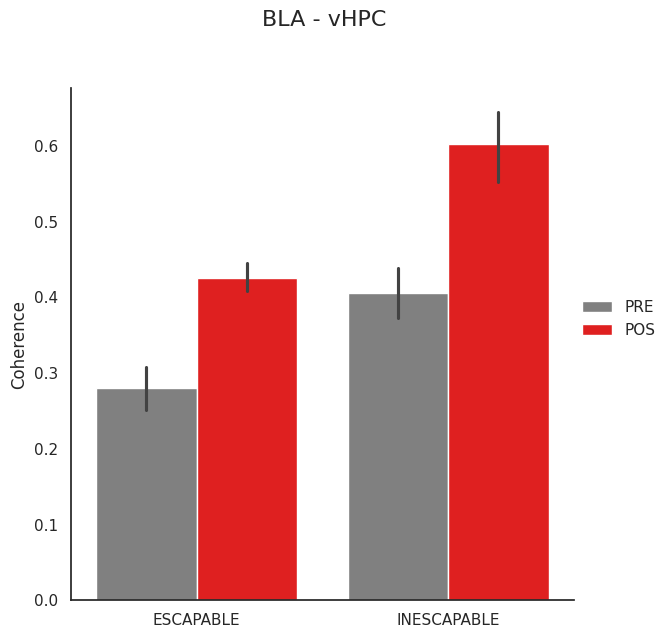

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta = df_coherence_all_animals[(df_coherence_all_animals['banda'] == 'Theta') &(df_coherence_all_animals['r1+r2'] == 'BLA_vHPC')]
df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_theta, kind="bar",
    x="grupo", y="coherence", hue="condicao",
    errorbar='ci', palette=['grey', 'red'], alpha=1, height=6,
)

# df_swarmplot_theta_BLA_vHPC = coh_theta_por_animal[(coh_theta_por_animal['r1+r2'] == 'BLA_vHPC')]


# sns.swarmplot(
#     data=df_swarmplot_theta_PRL_dHPC, x="grupo", y="coherence", hue="condicao",
#     color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
# )




# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("BLA - vHPC", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)

# sns.despine(bottom=True)
g.set_axis_labels("", 'Coherence')
g.legend.set_title("")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-63-1475b27fe8ef>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)


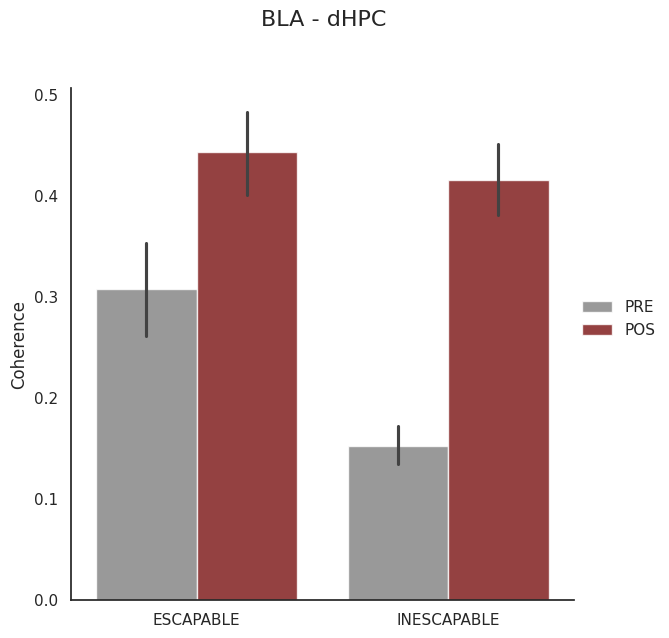

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

df_barplot_theta = df_coherence_all_animals[(df_coherence_all_animals['banda'] == 'Theta') &(df_coherence_all_animals['r1+r2'] == 'BLA_dHPC')]
df_barplot_theta['condicao'] = pd.Categorical(df_barplot_theta['condicao'], categories=["PRE", "POS"], ordered=True)

g = sns.catplot(
    data=df_barplot_theta, kind="bar",
    x="grupo", y="coherence", hue="condicao",
    errorbar='ci', palette=['grey', 'darkred'], alpha=0.8, height=6,
)

# df_swarmplot_theta_PRL = psd_theta_por_animal[(psd_theta_por_animal['REGIAO'] == 'PRL')]


# sns.swarmplot(
#     data=df_swarmplot_theta_PRL, x="GRUPO", y="PSD", hue="CONDICAO",
#     color="k", size=7, dodge=True, alpha=0.7 , legend=False   #, ax=g.ax
# )



# g.ax.axhline(y=690, color='black', linestyle='-', linewidth=1.5, xmin=0.05, xmax=0.25)
# g.ax.text(0,690, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.4, xmax=0.6)
# g.ax.text(1,530, '***', color='black', fontsize=12, ha='center')

# g.ax.axhline(y=530, color='black', linestyle='-', linewidth=1.5, xmin=0.75, xmax=0.95)
# g.ax.text(2,530, '***', color='black', fontsize=12, ha='center')


titulo_principal = plt.suptitle("BLA - dHPC", fontsize=16)
titulo_principal.set_y(1.1)

# g.despine(left=True)

# sns.despine(bottom=True)
g.set_axis_labels("", 'Coherence')
g.legend.set_title("")
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

> # ESTATÍSTICA

In [ ]:
df_anova = df_coherence_all_animals[df_coherence_all_animals['banda']=='Theta']
# df_anova['REGIAO'] = df_anova['REGIAO'].astype('category')
# df_anova['CONDICAO'] = df_anova['CONDICAO'].astype('category')
# df_anova['GRUPO'] = df_anova['GRUPO'].astype('category')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_anova

,coherence,f,animal,condicao,grupo,r1,r2,r1+r2,banda,indice
41,0.370671,4.1,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Theta,41
42,0.366416,4.2,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Theta,42
43,0.361074,4.3,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Theta,43
44,0.354467,4.4,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Theta,44
45,0.346347,4.5,CCM68,PRE,ESCAPABLE,PRL,BLA,PRL_BLA,Theta,45
...,...,...,...,...,...,...,...,...,...,...
96,0.364541,9.6,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,Theta,96
97,0.327043,9.7,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,Theta,97
98,0.285364,9.8,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,Theta,98
99,0.240391,9.9,CCM193,POS,INESCAPABLE,dHPC,vHPC,dHPC_vHPC,Theta,99


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Modelo ANOVA de duas vias
modelo = ols('coherence ~ C(grupo) + C(condicao) + C(r1+r2) +C(grupo):C(condicao)', data=df_anova).fit()
anova_table = sm.stats.anova_lm(modelo, typ=2)
print(anova_table)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

                          sum_sq      df           F         PR(>F)
C(grupo)                4.155417     1.0   96.546477   1.501342e-22
C(condicao)            35.426764     1.0  823.101242  8.099503e-166
C(r1 + r2)             24.845187     5.0  115.450027  7.085382e-115
C(grupo):C(condicao)    1.300929     1.0   30.225641   4.068167e-08
Residual              185.547990  4311.0         NaN            NaN


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

for regiao in df_anova['r1+r2'].unique():
    # Filtrando o DataFrame para a região atual
    df_regiao = df_anova[df_anova['r1+r2'] == regiao]

    # Ajustando o modelo ANOVA
    modelo = ols('coherence ~ C(grupo) + C(condicao)  ', data=df_regiao).fit()

    # Realizando a ANOVA
    anova_table = sm.stats.anova_lm(modelo, typ=2)

    # Imprimindo os resultados para a região atual
    print(f'ANOVA para: {regiao}')
    print(anova_table)


ANOVA para: PRL_BLA
                sum_sq     df          F        PR(>F)
C(grupo)      1.557223    1.0  40.669226  3.230234e-10
C(condicao)   2.433401    1.0  63.551914  6.161314e-15
Residual     27.453906  717.0        NaN           NaN
ANOVA para: PRL_dHPC
                sum_sq     df           F        PR(>F)
C(grupo)      0.105512    1.0    3.596843  5.829108e-02
C(condicao)   9.535328    1.0  325.054995  3.277153e-60
Residual     21.032841  717.0         NaN           NaN
ANOVA para: PRL_vHPC
                sum_sq     df           F        PR(>F)
C(grupo)      4.122768    1.0  144.864813  1.610679e-30
C(condicao)   4.741837    1.0  166.617484  2.002649e-34
Residual     20.405404  717.0         NaN           NaN
ANOVA para: BLA_vHPC
                sum_sq     df           F        PR(>F)
C(grupo)      4.074368    1.0   79.031126  4.903114e-18
C(condicao)   5.287407    1.0  102.560624  1.276447e-22
Residual     36.964197  717.0         NaN           NaN
ANOVA para: BLA_dHPC
    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
